# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize raw predictors](#Summarize-raw-predictors)
 1. [Summarize standardized predictor distributions](#Summarize-standardized-predictor-distributions)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted distances](#Summarize-observed-and-predicted-distances)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns

%matplotlib inline

In [100]:
sns.set_style("white")
plt.style.use("huddlej")

In [106]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4):
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=15)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings
[back to top](#Summarize-models)

In [6]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-delta_frequency",
    "lbi-dms_star",
    "lbi-ep_x-ne_star"
]

predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star"
]

In [7]:
data_root = "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data
[back to top](#Summarize-models)

In [8]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv", parse_dates=["timepoint"])

In [9]:
tips_to_clades_df = pd.read_table(data_root + "tips_to_clades.tsv", parse_dates=["timepoint"])

In [10]:
model_jsons = glob.glob(data_root + "models/*.json")

In [11]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [12]:
models_by_predictors["lbi"]["cost_function"]

'diffsum'

In [13]:
models_by_predictors["lbi"]["l1_lambda"]

0.0

In [14]:
models_by_predictors["lbi"]["training_window"]

6

In [15]:
models_by_predictors["lbi"]["pseudocount"]

0.0

In [16]:
type(models_by_predictors["lbi"])

dict

In [17]:
models_by_predictors.keys()

dict_keys(['dms_star', 'ep', 'lbi', 'ne_star', 'delta_frequency', 'cTiterSub_x', 'ep_x', 'naive', 'cTiterSub'])

In [18]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [19]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [20]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

387

In [21]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [22]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[15.619402060822111]

In [23]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [24]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])

        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "strain"], suffixes=["", "_hat"])
        frequency_df["residual"] = frequency_df["y"] - frequency_df["y_hat"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        training_X = pd.DataFrame(scores["training_data"]["X"])
        training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "strain"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["y"] - residual_df["y_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [25]:
residual_df.head()

strain  timepoint         y  frequency  projected_frequency  \
0    A/California/7/2004 2004-10-01  0.373942   0.063517             0.001484   
1  A/Canterbury/201/2004 2004-10-01  0.265254   0.063517             0.024033   
2   A/Canterbury/23/2004 2004-10-01  0.273124   0.085993             0.167534   
3     A/England/909/2003 2004-10-01  0.000077   0.000009             0.000003   
4   A/Hanoi/HN30147/2004 2004-10-01  0.024772   0.003242             0.000004   

   weighted_distance_to_future  weighted_distance_to_present     y_hat  \
0                     5.887278                      6.124823  0.324750   
1                     4.176117                      4.492171  0.202588   
2                     3.176116                      3.619208  0.192416   
3                     8.603379                      6.270080  0.000054   
4                     7.640958                      5.923253  0.017036   

     y_diff  residual validation_timepoint predictors  
0  0.008735  0.049192           2011-10-01   dms_star  
1  0.100365  0.062666           2011-10-01   dms_star  
2  0.532108  0.080708           2011-10-01   dms_star  
3  0.000025  0.000024           2011-10-01   dms_star  
4  0.000027  0.007736           2011-10-01   dms_star

In [26]:
training_y.head()

strain  timepoint         y
0       A/Argentina/3726/2007 2007-10-01  0.104053
1      A/Bangladesh/1695/2007 2007-10-01  0.322274
2      A/Bangladesh/4699/2007 2007-10-01  0.126474
3      A/Bangladesh/9745/2007 2007-10-01  0.105049
4  A/Beijing/XICHENG1272/2006 2007-10-01  0.000038

In [27]:
training_y_hat.head()

frequency  projected_frequency                      strain  timepoint  \
0   0.029448             0.015167       A/Argentina/3726/2007 2007-10-01   
1   0.034703             0.017874      A/Bangladesh/1695/2007 2007-10-01   
2   0.027898             0.014369      A/Bangladesh/4699/2007 2007-10-01   
3   0.029730             0.015312      A/Bangladesh/9745/2007 2007-10-01   
4   0.000004             0.000002  A/Beijing/XICHENG1272/2006 2007-10-01   

   weighted_distance_to_future  weighted_distance_to_present         y  \
0                     3.533435                      2.581204  0.110557   
1                     9.286621                      8.138137  0.296920   
2                     4.533436                      3.525408  0.131834   
3                     3.533435                      2.581204  0.111616   
4                     9.423960                      7.688796  0.000037   

     y_diff  
0  0.053592  
1  0.165985  
2  0.065139  
3  0.054105  
4  0.000019

In [28]:
residual_df.head()

strain  timepoint         y  frequency  projected_frequency  \
0    A/California/7/2004 2004-10-01  0.373942   0.063517             0.001484   
1  A/Canterbury/201/2004 2004-10-01  0.265254   0.063517             0.024033   
2   A/Canterbury/23/2004 2004-10-01  0.273124   0.085993             0.167534   
3     A/England/909/2003 2004-10-01  0.000077   0.000009             0.000003   
4   A/Hanoi/HN30147/2004 2004-10-01  0.024772   0.003242             0.000004   

   weighted_distance_to_future  weighted_distance_to_present     y_hat  \
0                     5.887278                      6.124823  0.324750   
1                     4.176117                      4.492171  0.202588   
2                     3.176116                      3.619208  0.192416   
3                     8.603379                      6.270080  0.000054   
4                     7.640958                      5.923253  0.017036   

     y_diff  residual validation_timepoint predictors  
0  0.008735  0.049192           2011-10-01   dms_star  
1  0.100365  0.062666           2011-10-01   dms_star  
2  0.532108  0.080708           2011-10-01   dms_star  
3  0.000025  0.000024           2011-10-01   dms_star  
4  0.000027  0.007736           2011-10-01   dms_star

In [29]:
residual_df.shape

(48195, 12)

In [30]:
frequency_df.head()

strain  timepoint         y  frequency  \
0     A/Adjame/GR765/2011 2011-10-01  0.141029   0.016677   
1   A/Argentina/8823/2011 2011-10-01  0.245632   0.022372   
2  A/Bangladesh/3564/2011 2011-10-01  0.158091   0.022640   
3  A/Bangladesh/5006/2011 2011-10-01  0.130892   0.021878   
4  A/Bangladesh/5071/2011 2011-10-01  0.128122   0.021415   

   projected_frequency  weighted_distance_to_future  \
0             0.002071                     8.456494   
1             0.030713                    10.979448   
2             0.002705                     6.982831   
3             0.030035                     5.982827   
4             0.029399                     5.982827   

   weighted_distance_to_present     y_hat    y_diff  residual  \
0                      7.895304  0.130228  0.017514  0.010801   
1                      7.955716  0.166173  0.337211  0.079459   
2                      7.101683  0.160841  0.018887 -0.002750   
3                      6.159798  0.133701  0.179693 -0.002809   
4                      6.159798  0.130872  0.175890 -0.002749   

  validation_timepoint predictors  
0           2011-10-01   dms_star  
1           2011-10-01   dms_star  
2           2011-10-01   dms_star  
3           2011-10-01   dms_star  
4           2011-10-01   dms_star

In [31]:
overall_errors_df.sort_values("cv_error_mean")

cv_error_mean  cv_error_std       predictors
4       6.216407      1.797866  delta_frequency
2       6.400644      2.756756              lbi
3       7.877691      1.522119          ne_star
5       7.955056      1.032993      cTiterSub_x
8       8.052613      1.536841        cTiterSub
7       8.334149      0.980848            naive
0       8.419457      0.995534         dms_star
1       9.312149      1.388986               ep
6      10.621579      2.129400             ep_x

In [32]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          8.727901            83           2011-10-01
1   dms_star          9.027530            88           2012-04-01
2   dms_star          8.318345            87           2012-10-01
3   dms_star          6.902983            87           2013-04-01
4   dms_star          7.025528            92           2013-10-01

In [33]:
frequency_df.head()

strain  timepoint         y  frequency  \
0     A/Adjame/GR765/2011 2011-10-01  0.141029   0.016677   
1   A/Argentina/8823/2011 2011-10-01  0.245632   0.022372   
2  A/Bangladesh/3564/2011 2011-10-01  0.158091   0.022640   
3  A/Bangladesh/5006/2011 2011-10-01  0.130892   0.021878   
4  A/Bangladesh/5071/2011 2011-10-01  0.128122   0.021415   

   projected_frequency  weighted_distance_to_future  \
0             0.002071                     8.456494   
1             0.030713                    10.979448   
2             0.002705                     6.982831   
3             0.030035                     5.982827   
4             0.029399                     5.982827   

   weighted_distance_to_present     y_hat    y_diff  residual  \
0                      7.895304  0.130228  0.017514  0.010801   
1                      7.955716  0.166173  0.337211  0.079459   
2                      7.101683  0.160841  0.018887 -0.002750   
3                      6.159798  0.133701  0.179693 -0.002809   
4                      6.159798  0.130872  0.175890 -0.002749   

  validation_timepoint predictors  
0           2011-10-01   dms_star  
1           2011-10-01   dms_star  
2           2011-10-01   dms_star  
3           2011-10-01   dms_star  
4           2011-10-01   dms_star

## Summarize raw predictors
[back to top](#Summarize-models)

In [34]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

In addition to the raw tip attributes, load the standardization metrics associated with each predictor for comparison to the overall distributions per predictor per timepoint shown below.

In [35]:
standardization_stats = pd.read_csv(data_root + "standardization_statistics.json", sep="\t")

In [36]:
standardization_stats

mean        var        predictor
0   1.749002   0.615486        cTiterSub
1  -6.472070   0.265264      cTiterSub_x
2   0.259315   0.407845  delta_frequency
3  -1.648721  10.960136         dms_star
4  10.762712   3.706406               ep
5  -3.507489   0.366448             ep_x
6   0.234801   0.022212              lbi
7   0.000000   0.000000            naive
8   0.972267   0.865925          ne_star

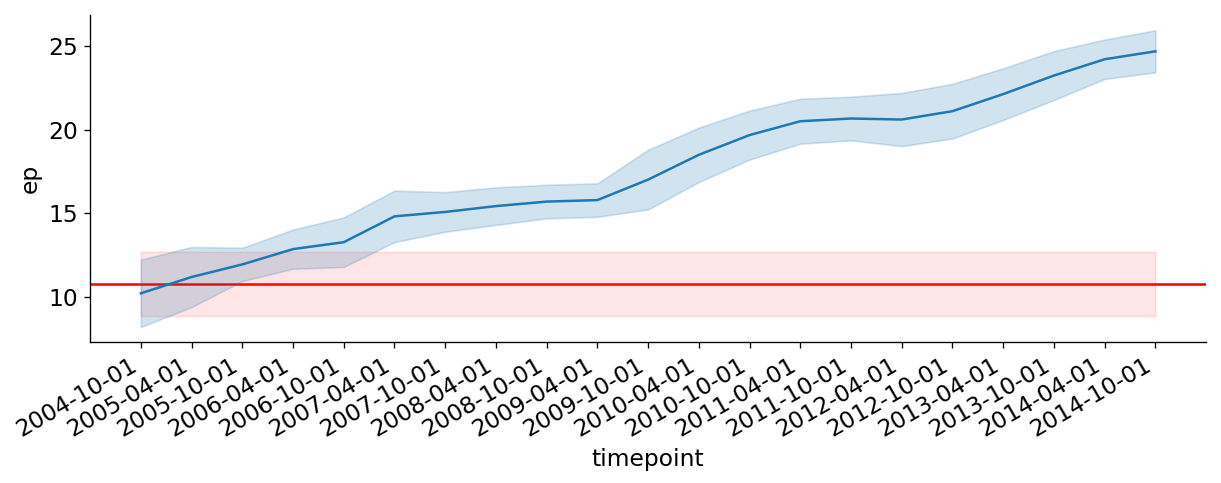

In [37]:
predictor = "ep"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'Epitope cross-immunity')

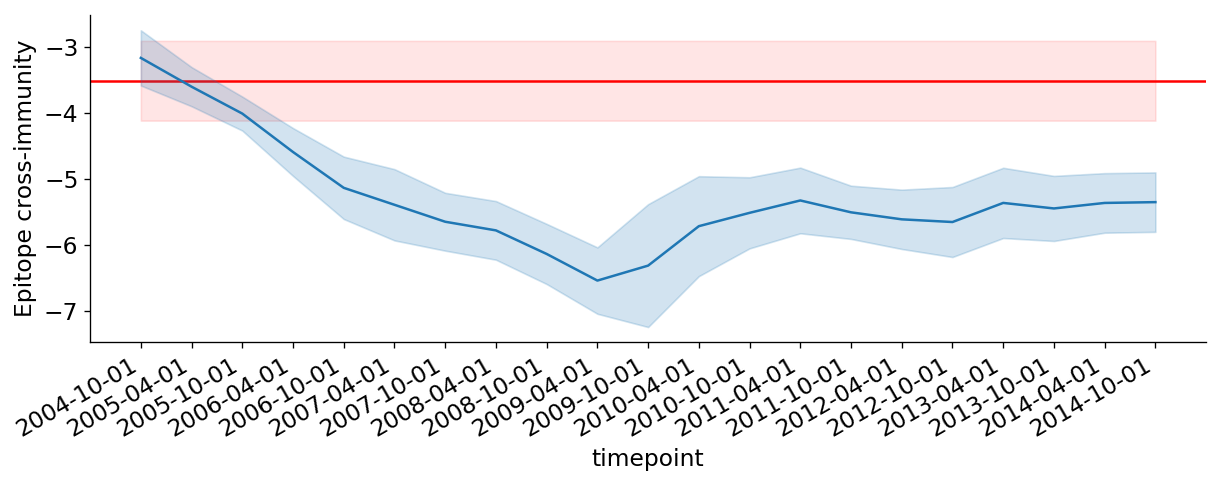

In [38]:
predictor = "ep_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)
ax.set_ylabel("Epitope cross-immunity")

Text(0,0.5,'std dev of ep_x')

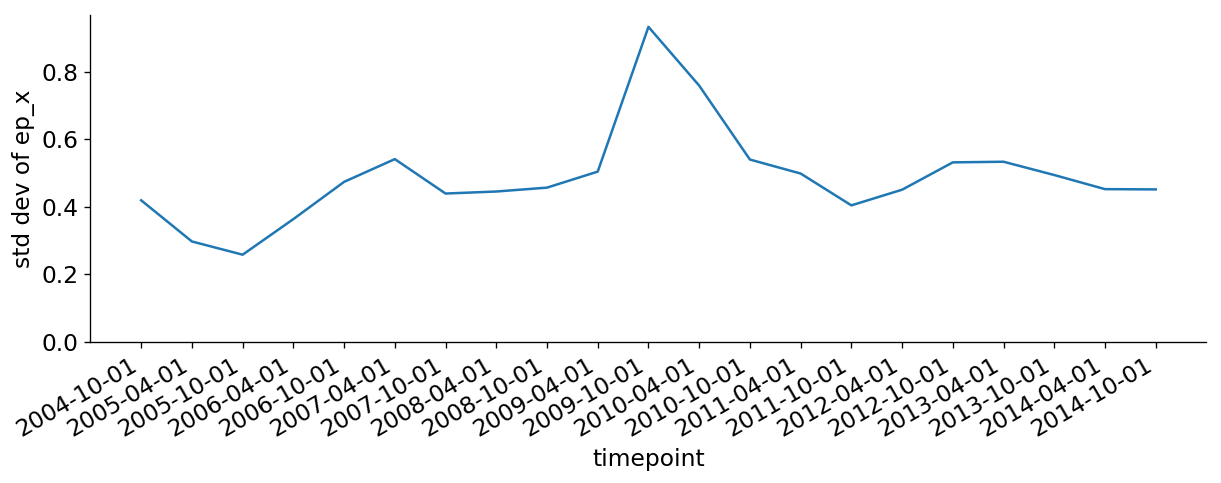

In [39]:
predictor = "ep_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    estimator="std",
    ci=None,
    ax=ax
)
plt.gcf().autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("std dev of %s" % predictor)

In [ ]:
predictor = "ep_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

In [ ]:
predictor = "cTiterSub_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'HI cross-immunity')

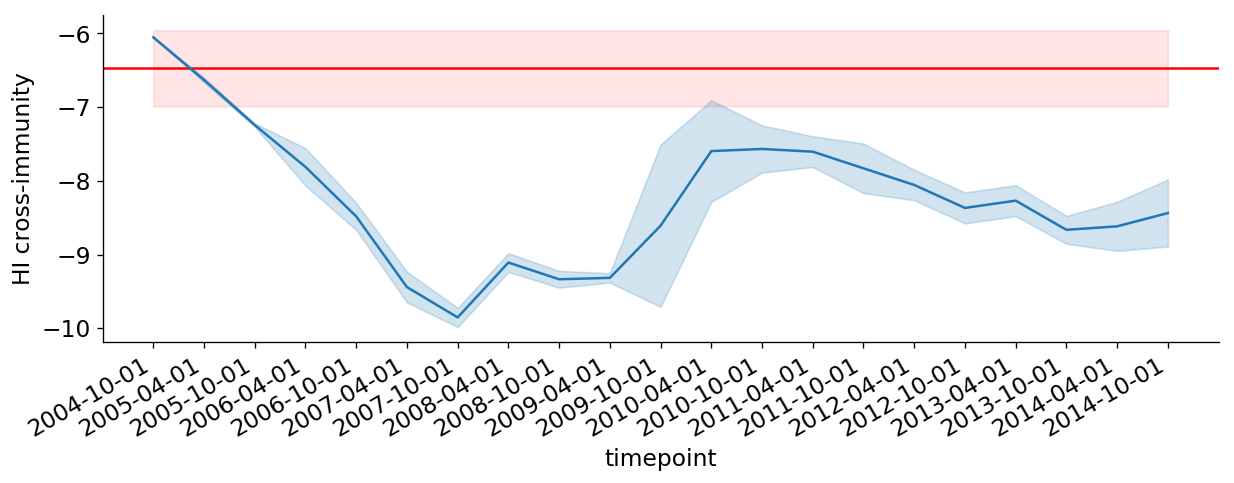

In [40]:
predictor = "cTiterSub_x"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)
ax.set_ylabel("HI cross-immunity")

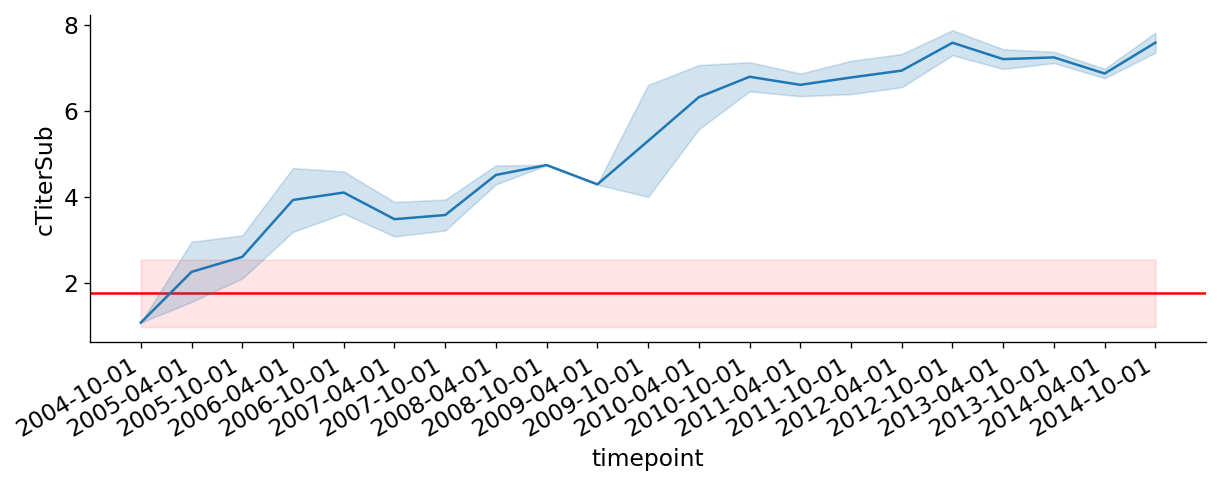

In [41]:
predictor = "cTiterSub"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

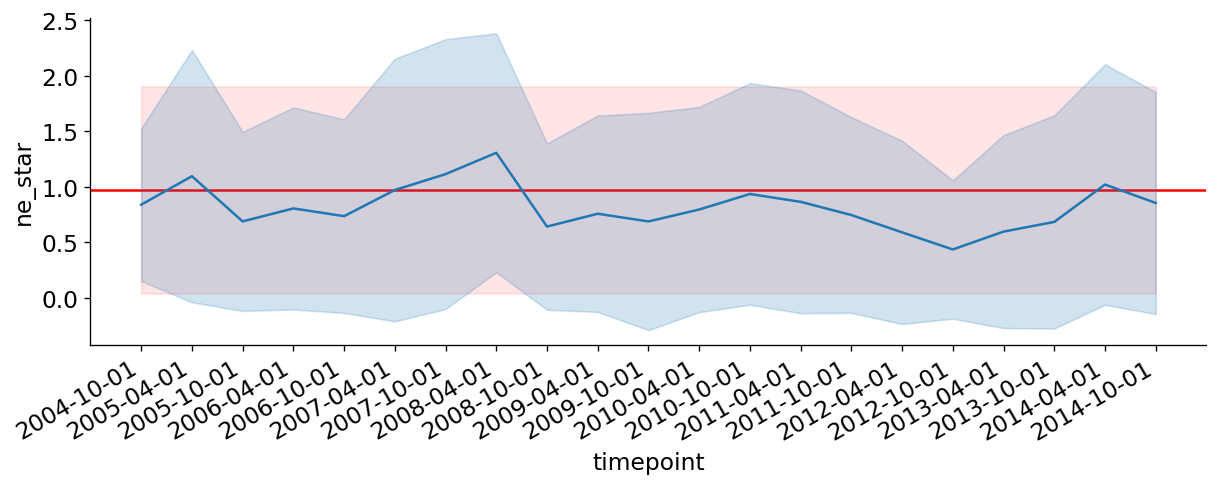

In [42]:
predictor = "ne_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

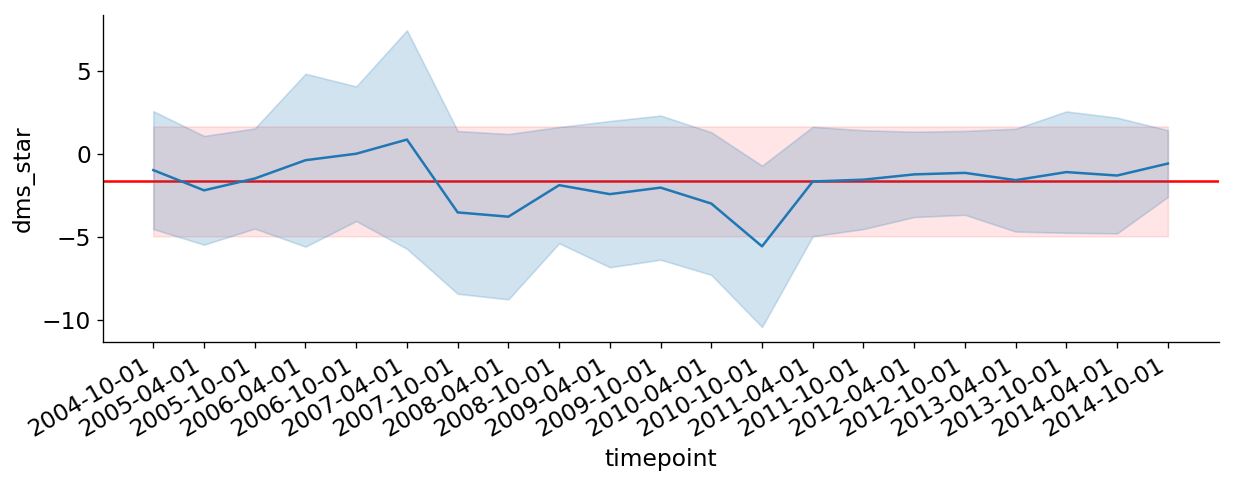

In [43]:
predictor = "dms_star"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

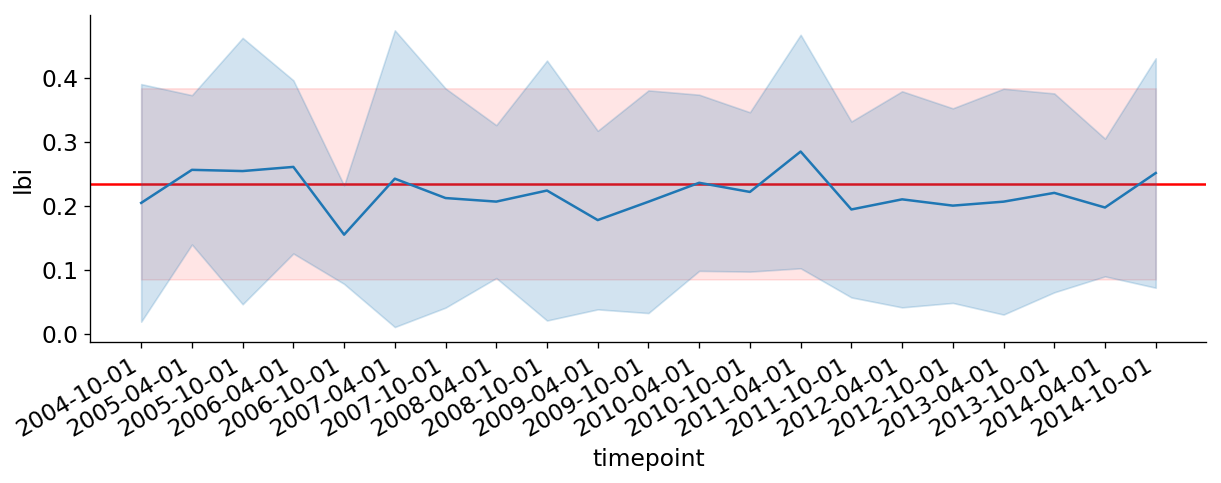

In [44]:
predictor = "lbi"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

Text(0,0.5,'std dev of lbi')

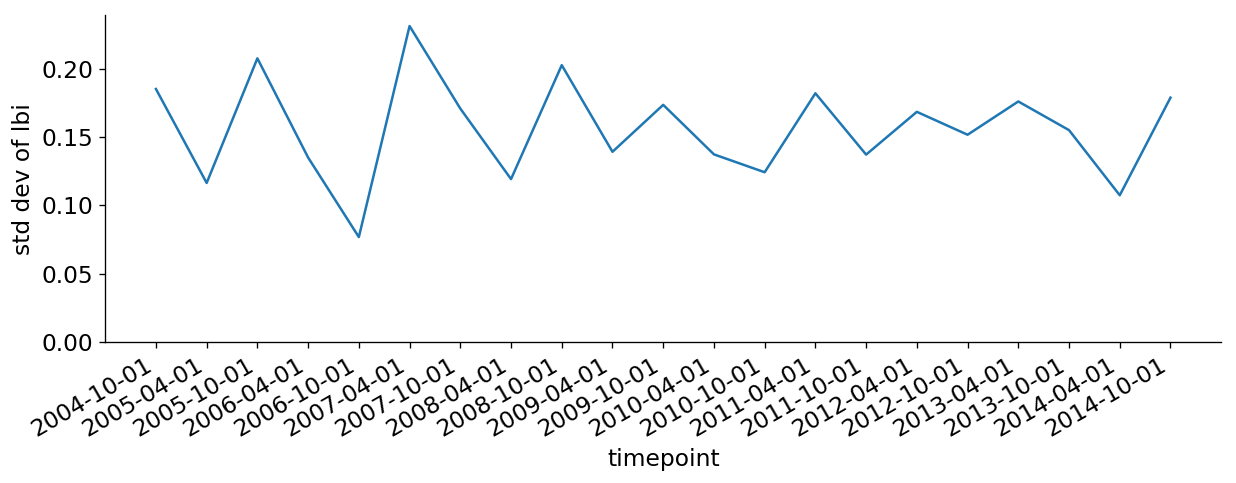

In [45]:
predictor = "lbi"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    estimator="std",
    ci=None,
    ax=ax
)
plt.gcf().autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("std dev of %s" % predictor)

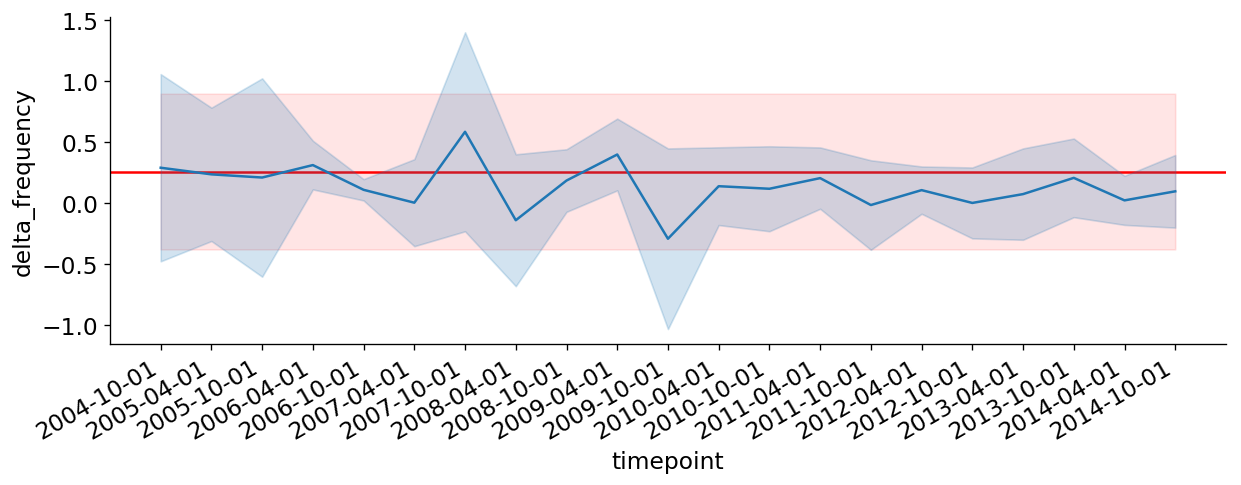

In [46]:
predictor = "delta_frequency"
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y=predictor,
    data=raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

# Draw the standardization mean and standard deviation for comparison.
mean = standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0]
std = np.sqrt(standardization_stats[standardization_stats["predictor"] == predictor]["var"].values[0])

ax.axhline(y=standardization_stats[standardization_stats["predictor"] == predictor]["mean"].values[0], color="red", zorder=-10)
ax.fill_between(
    raw_tip_attributes_df[raw_tip_attributes_df["timepoint"] < "2015-04-01"]["timepoint"].values,
    mean - std,
    mean + std,
    color="red",
    alpha=0.1,
    zorder=-10
)

## Summarize standardized predictor distributions
[back to top](#Summarize-models)

In [47]:
tip_attributes_df.shape

(1502, 34)

In [48]:
tip_attributes_df["ep_x"].head()

0    1.817003
1    0.869821
2    0.869821
3   -0.189384
4    0.536196
Name: ep_x, dtype: float64

In [49]:
tip_attributes_df["ep_x"].dropna().shape

(1502,)

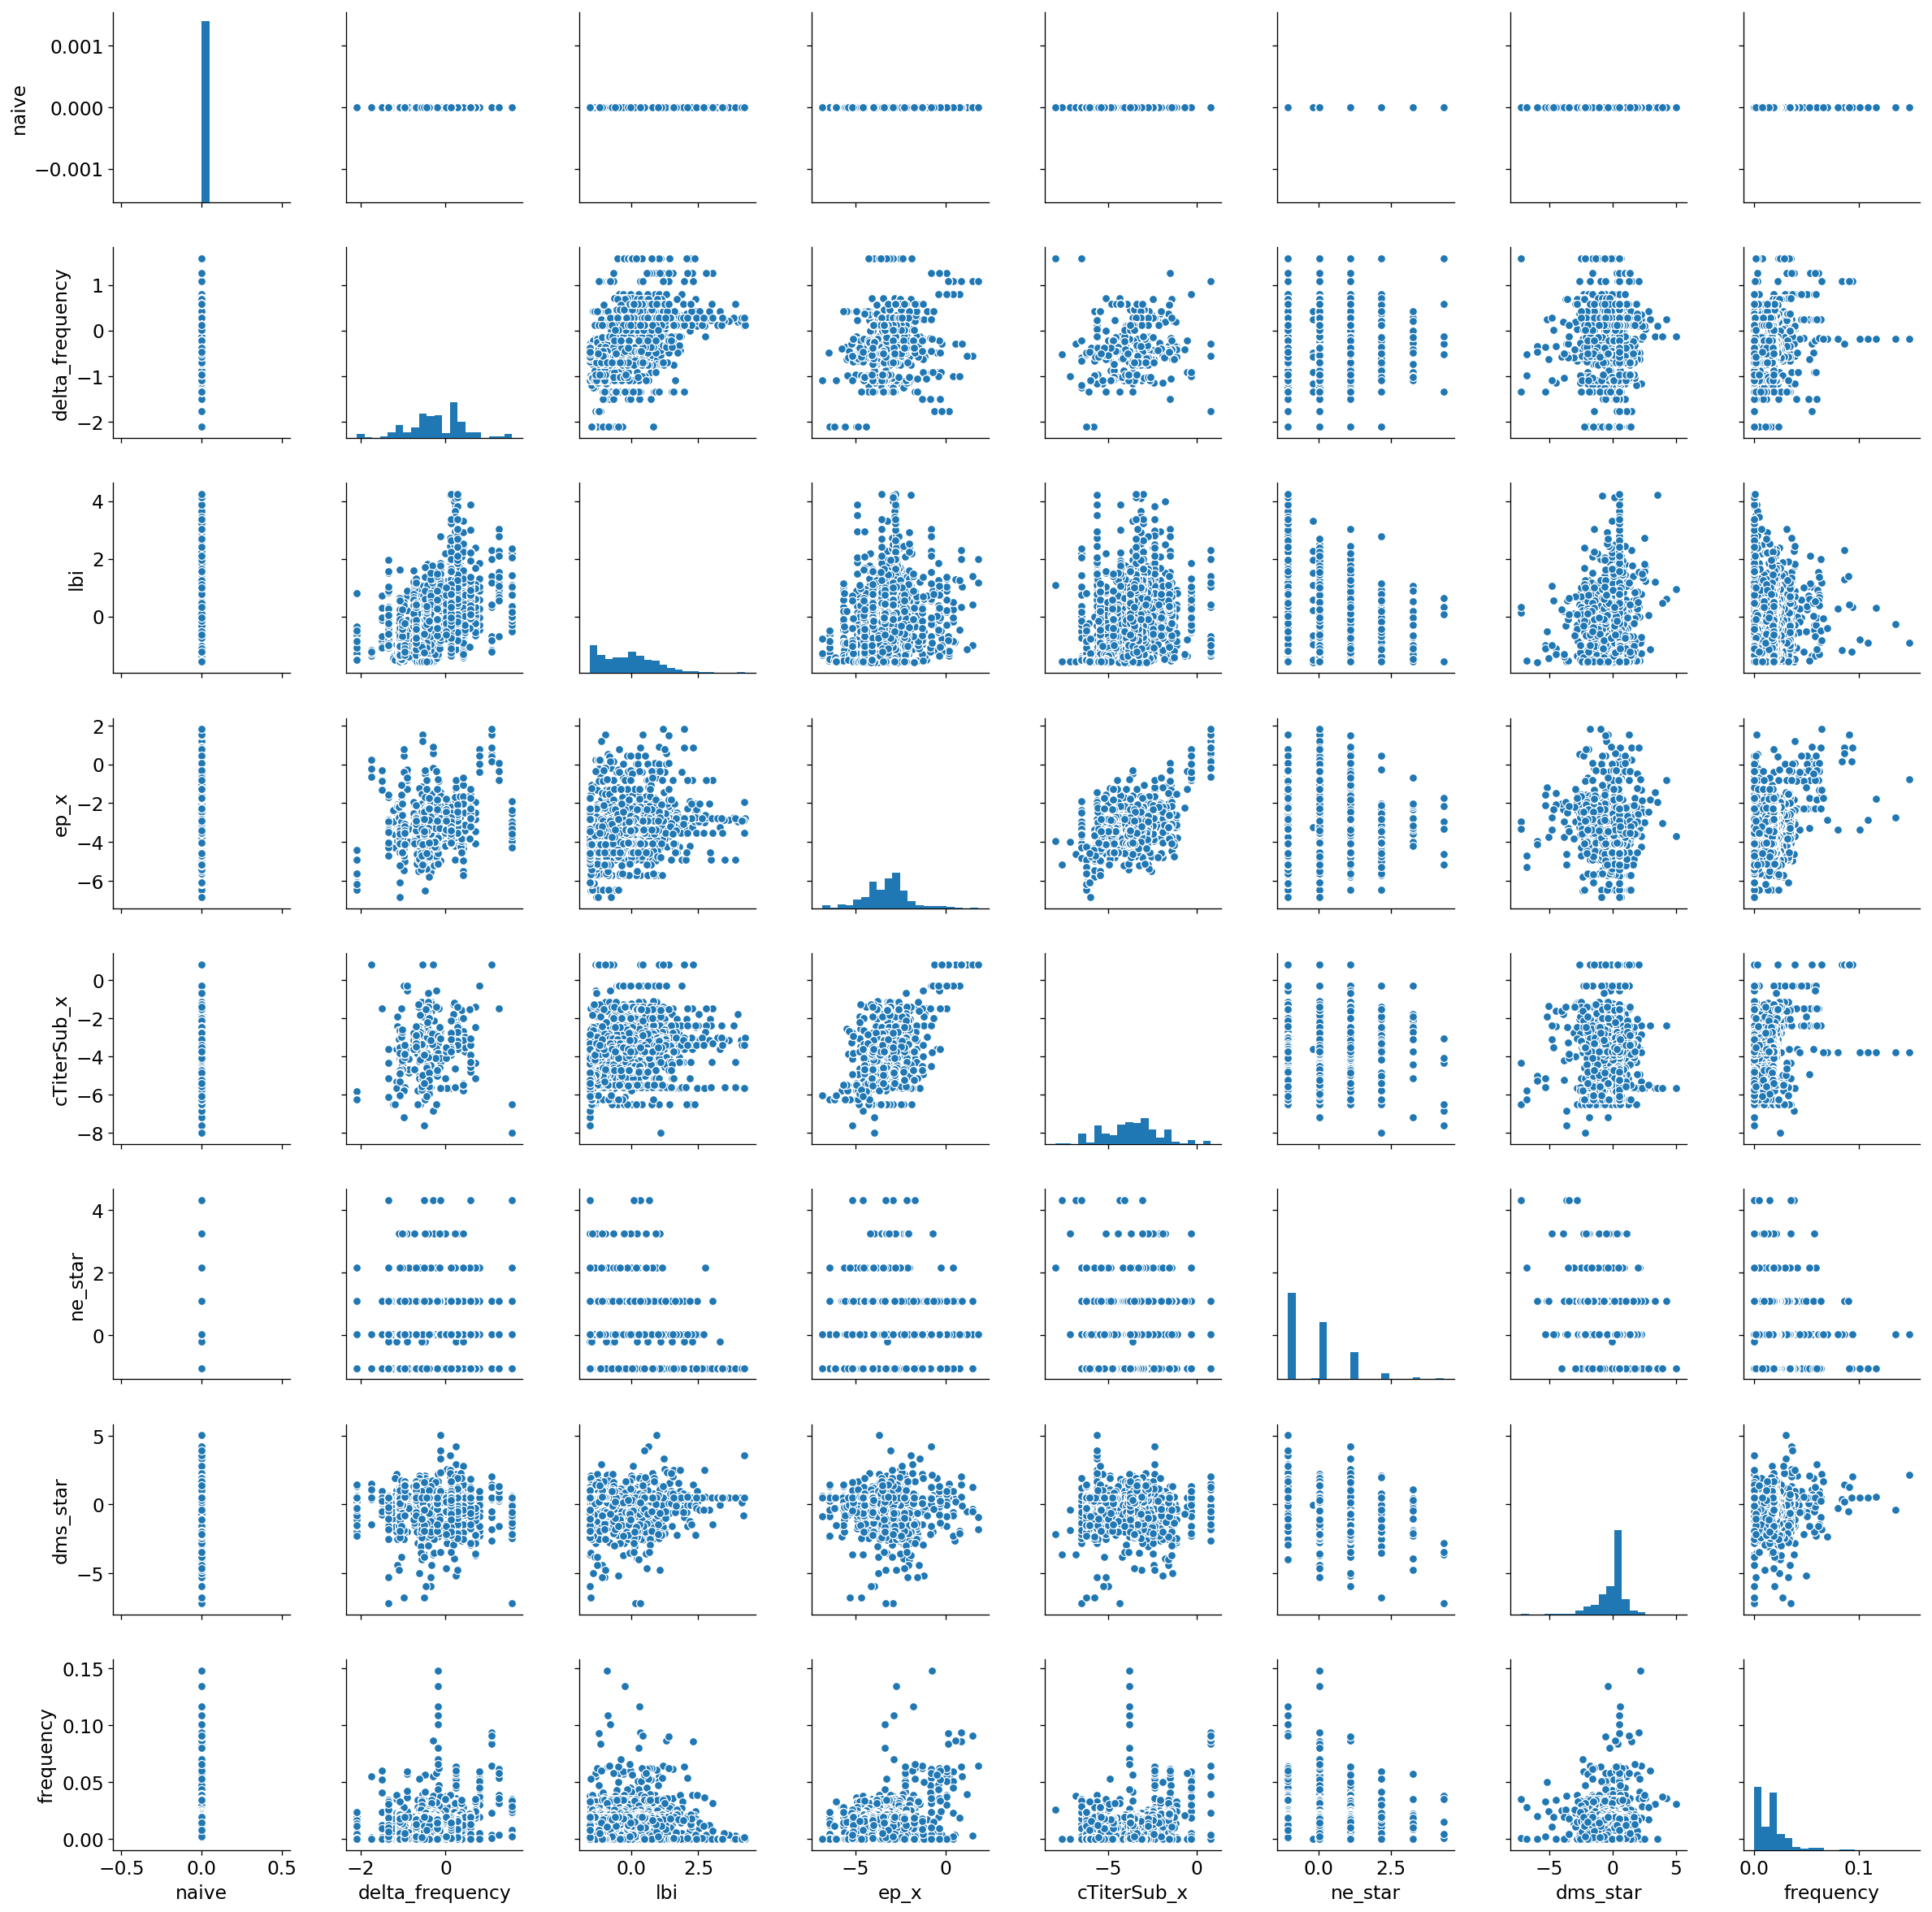

In [50]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df, vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

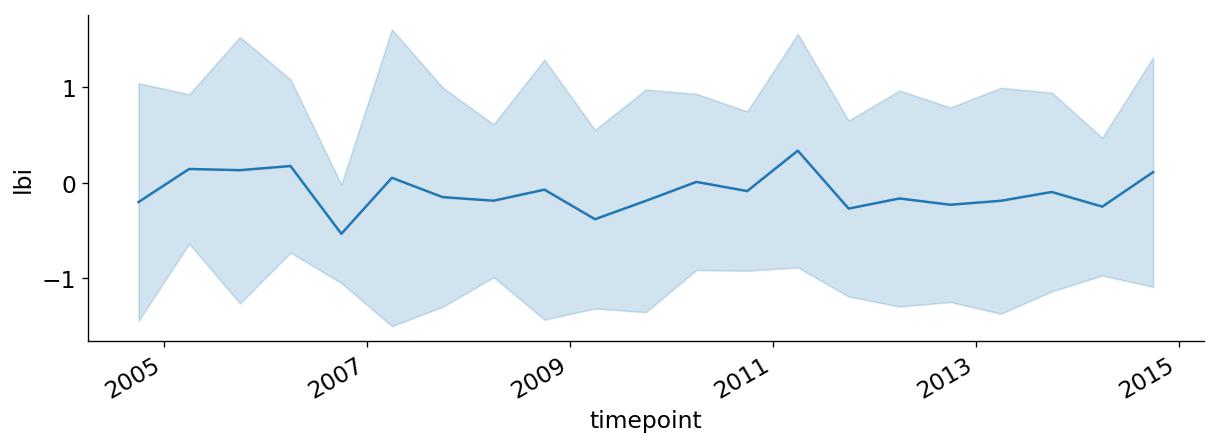

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y="lbi",
    data=tip_attributes_df[tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

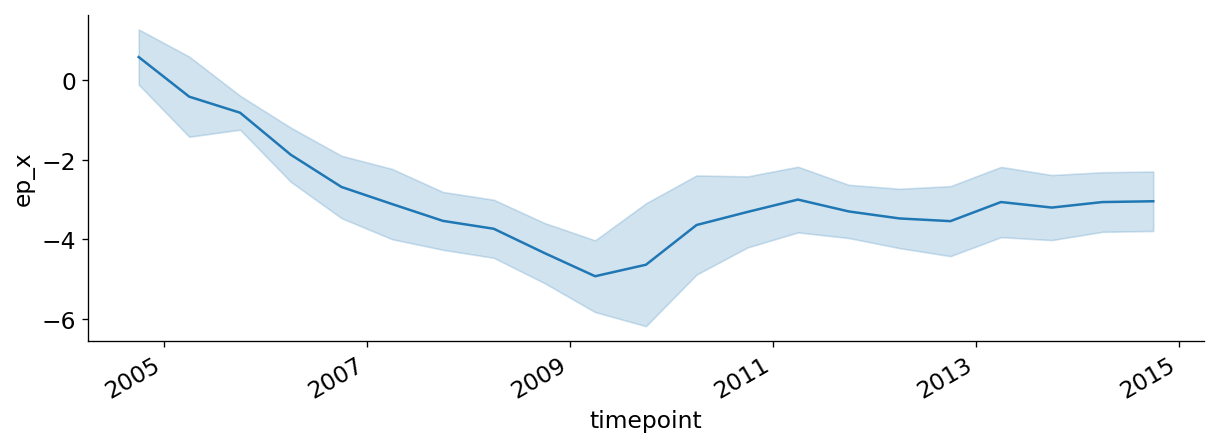

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(
    x="timepoint",
    y="ep_x",
    data=tip_attributes_df[tip_attributes_df["timepoint"] < "2015-04-01"],
    ci="sd",
    ax=ax
)
plt.gcf().autofmt_xdate()
#ax.set_ylim(bottom=0)

In [53]:
tip_attributes_df.loc[pd.isnull(tip_attributes_df["ep_x"]), ["strain", "timepoint", "frequency"]]

Empty DataFrame
Columns: [strain, timepoint, frequency]
Index: []

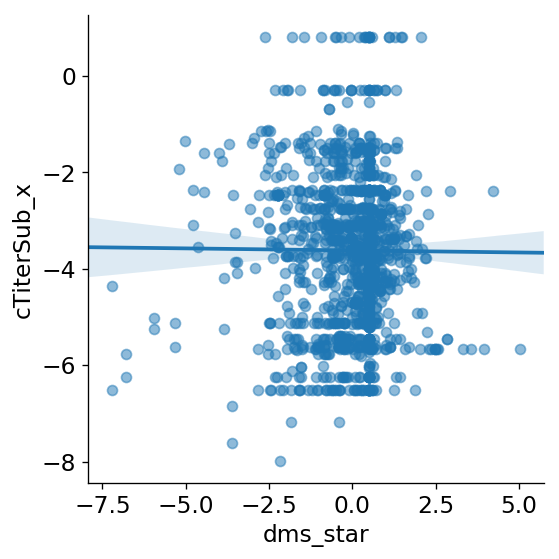

In [54]:
sns.lmplot("dms_star", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

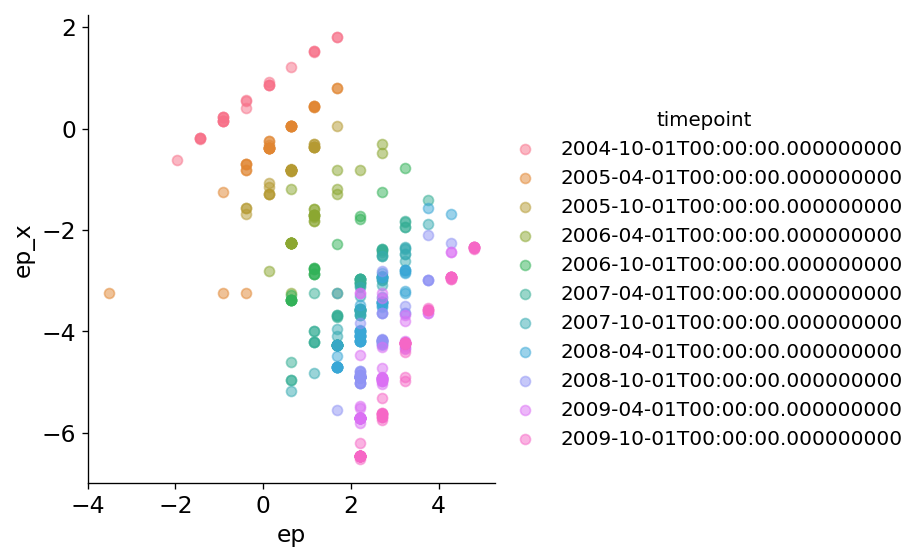

In [55]:
sns.lmplot("ep", "ep_x", tip_attributes_df[(tip_attributes_df["ep"] < 50) & (tip_attributes_df["timepoint"] < "2010-01-01")], hue="timepoint", scatter_kws={"alpha": 0.5}, fit_reg=False)



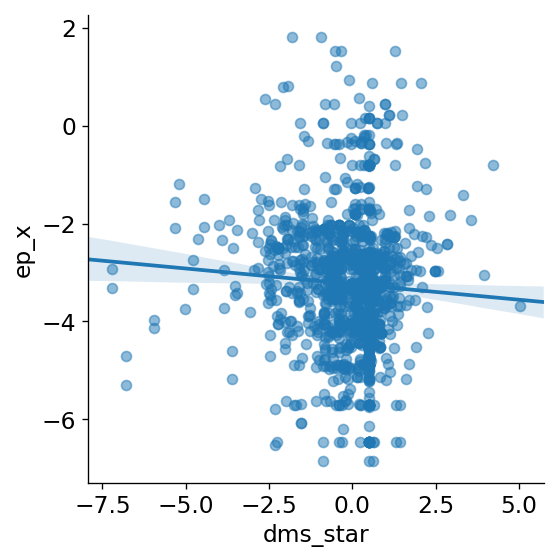

In [56]:
sns.lmplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

(-7, 7)

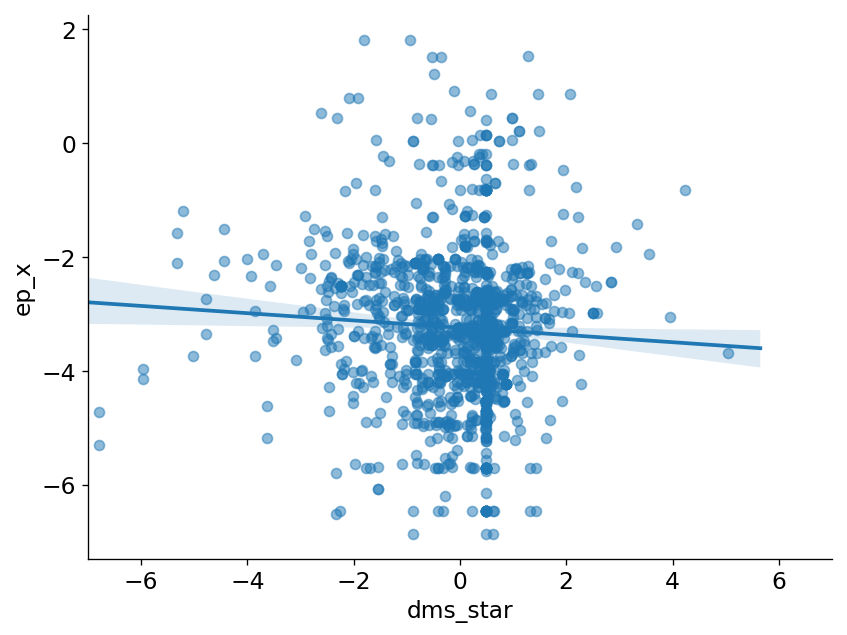

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)
ax.set_xlim(-7, 7)

In [58]:
tip_attributes_df.loc[tip_attributes_df["dms_star"] < -15, ["timepoint", "strain", "cTiterSub_x", "ep_x", "dms_star", "frequency", "raw_date"]].head()

Empty DataFrame
Columns: [timepoint, strain, cTiterSub_x, ep_x, dms_star, frequency, raw_date]
Index: []

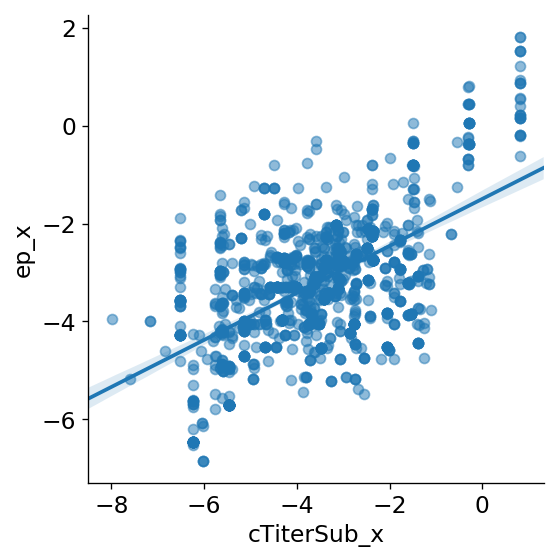

In [59]:
sns.lmplot("cTiterSub_x", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

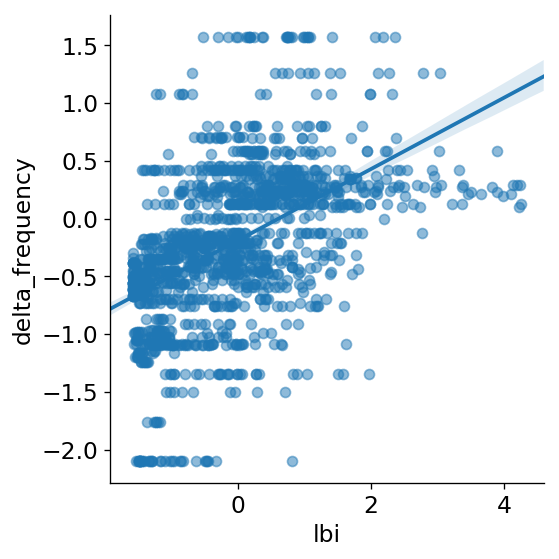

In [70]:
sns.lmplot("lbi", "delta_frequency", tip_attributes_df, scatter_kws={"alpha": 0.5})

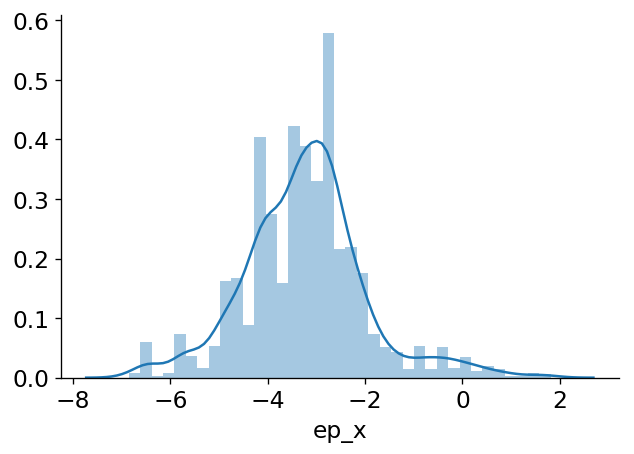

In [60]:
sns.distplot(tip_attributes_df["ep_x"])

In [61]:
tip_attributes_df["ep_x"].mean()

-3.23505689920688

In [62]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

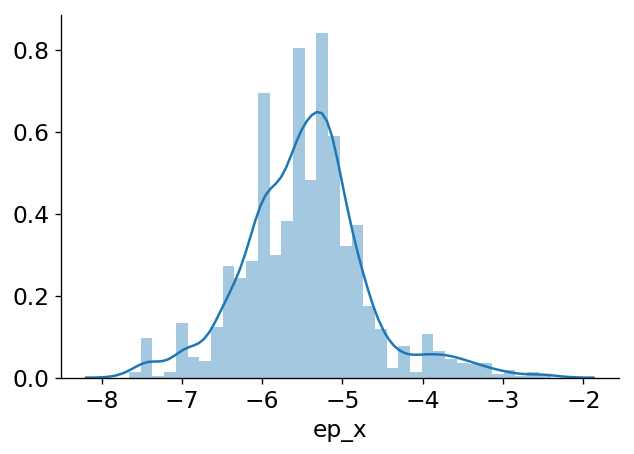

In [63]:
sns.distplot(raw_tip_attributes_df["ep_x"].dropna())

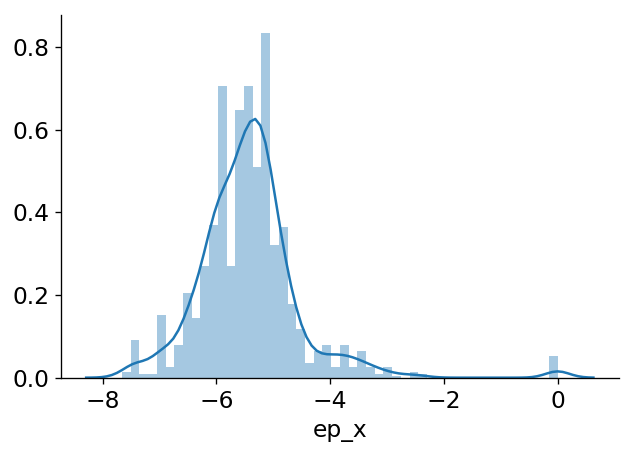

In [64]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(0.0))

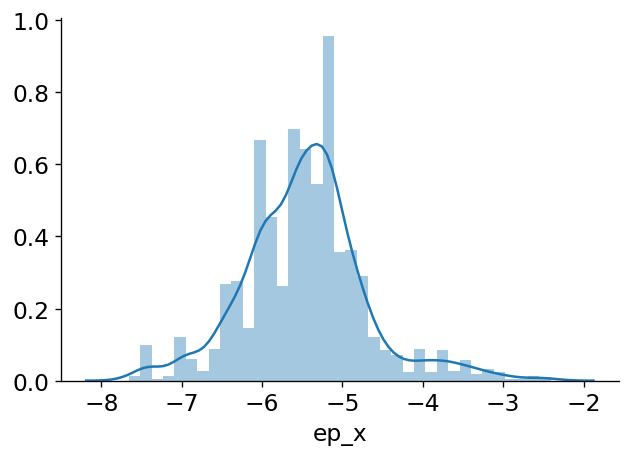

In [65]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(raw_tip_attributes_df["ep_x"].dropna().mean()))

In [66]:
raw_tip_attributes_df["ep_x"].dropna().mean()

-5.465829755998254

In [67]:
raw_tip_attributes_df["ep_x"].dropna().std()

0.7668272441174685

In [68]:
raw_tip_attributes_df["ep_x"].fillna(0.0).mean()

-5.422161342501597

In [69]:
raw_tip_attributes_df["ep_x"].fillna(0.0).std()

0.9056809007715909

## Summarize model residuals
[back to top](#Summarize-models)

In [71]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [72]:
residuals_by_timepoint.head()

predictors  timepoint   residual
0  cTiterSub 2004-10-01   1.247113
1  cTiterSub 2005-04-01   3.428067
2  cTiterSub 2005-10-01   5.536506
3  cTiterSub 2006-04-01  15.255691
4  cTiterSub 2006-10-01   9.071670

In [73]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
cTiterSub          160.085870
cTiterSub_x        146.702620
delta_frequency    232.240232
dms_star           144.994174
ep                 172.342941
ep_x               200.182063
lbi                265.948672
naive              157.278325
ne_star            241.436405
Name: residual, dtype: float64

In [74]:
model_name = "lbi"

In [75]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [76]:
max_lags = 18

Text(0,0.5,'Number of clades')

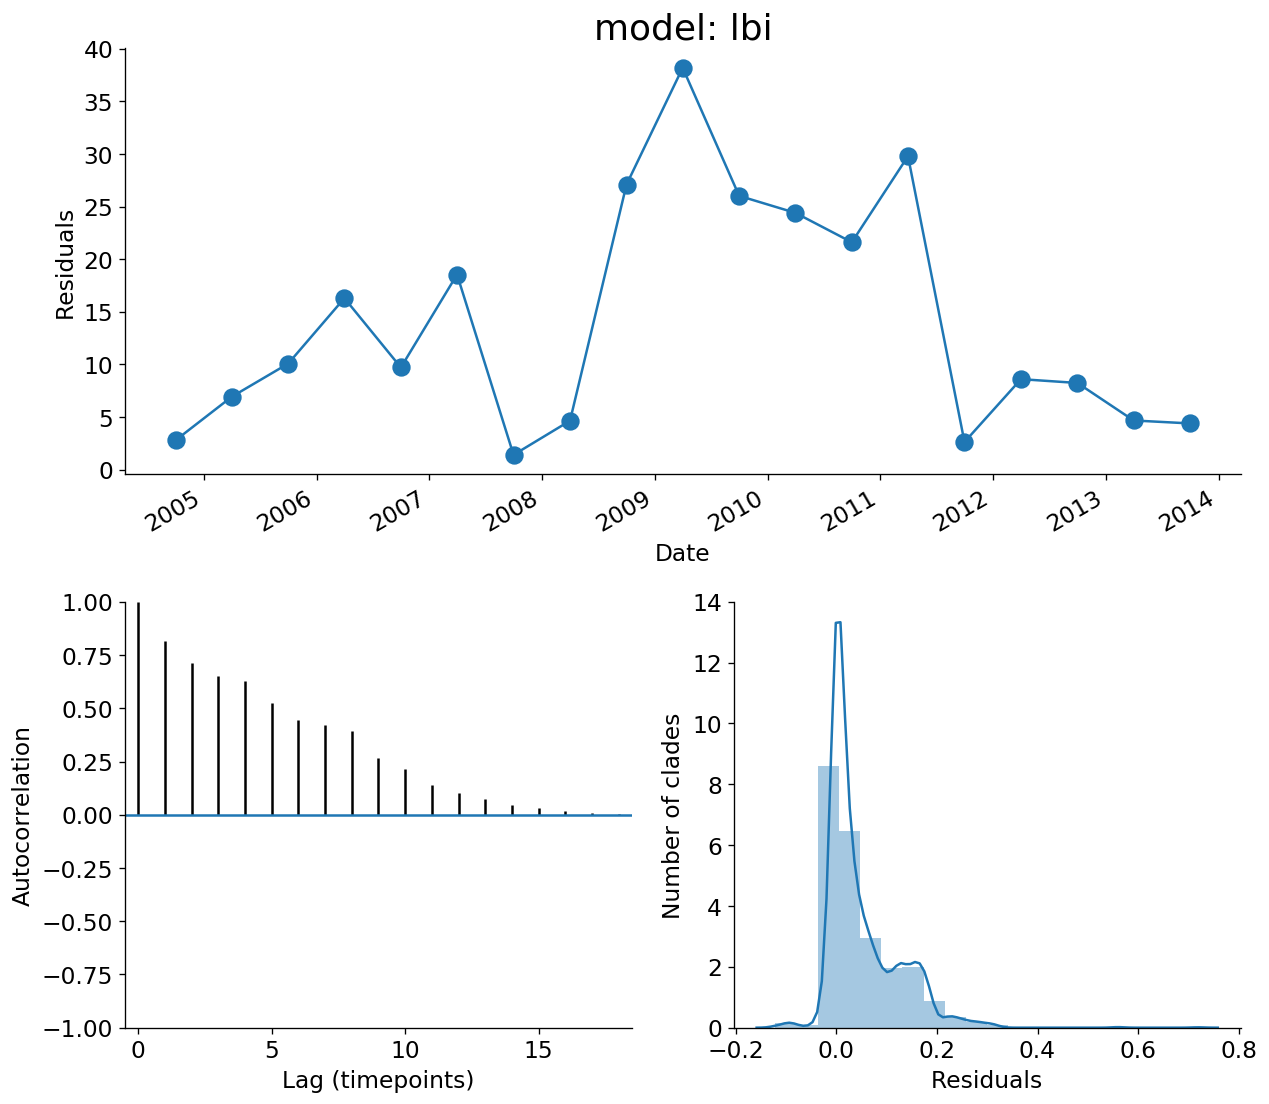

In [77]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [78]:
residual_df.head()

strain  timepoint         y  frequency  projected_frequency  \
0    A/California/7/2004 2004-10-01  0.373942   0.063517             0.001484   
1  A/Canterbury/201/2004 2004-10-01  0.265254   0.063517             0.024033   
2   A/Canterbury/23/2004 2004-10-01  0.273124   0.085993             0.167534   
3     A/England/909/2003 2004-10-01  0.000077   0.000009             0.000003   
4   A/Hanoi/HN30147/2004 2004-10-01  0.024772   0.003242             0.000004   

   weighted_distance_to_future  weighted_distance_to_present     y_hat  \
0                     5.887278                      6.124823  0.324750   
1                     4.176117                      4.492171  0.202588   
2                     3.176116                      3.619208  0.192416   
3                     8.603379                      6.270080  0.000054   
4                     7.640958                      5.923253  0.017036   

     y_diff  residual validation_timepoint predictors  
0  0.008735  0.049192           2011-10-01   dms_star  
1  0.100365  0.062666           2011-10-01   dms_star  
2  0.532108  0.080708           2011-10-01   dms_star  
3  0.000025  0.000024           2011-10-01   dms_star  
4  0.000027  0.007736           2011-10-01   dms_star

### Residuals by predictor

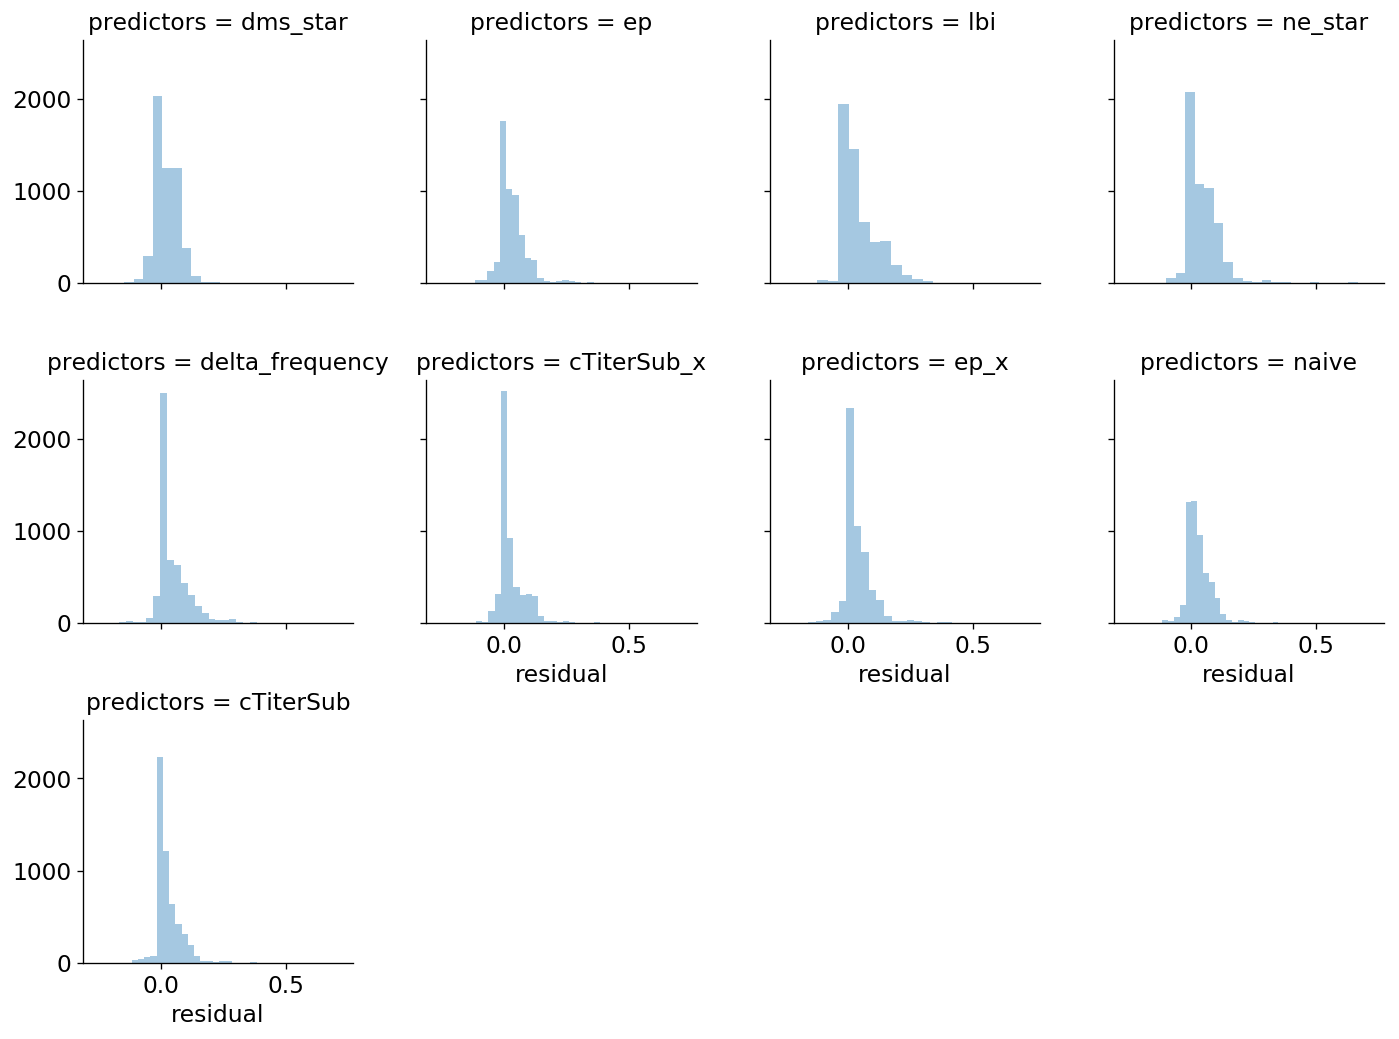

In [79]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20, kde=False)

In [80]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
cTiterSub_x        0.006105
dms_star           0.014315
cTiterSub          0.014768
naive              0.018495
delta_frequency    0.019944
lbi                0.020833
ep                 0.021940
ep_x               0.023202
ne_star            0.032962
Name: residual, dtype: float64

In [81]:
residual_df.groupby("predictors")["residual"].count()

predictors
cTiterSub          5355
cTiterSub_x        5355
delta_frequency    5355
dms_star           5355
ep                 5355
ep_x               5355
lbi                5355
naive              5355
ne_star            5355
Name: residual, dtype: int64

In [82]:
(residual_df["residual"] < -0.01).sum()

3348

### Residuals by timepoint

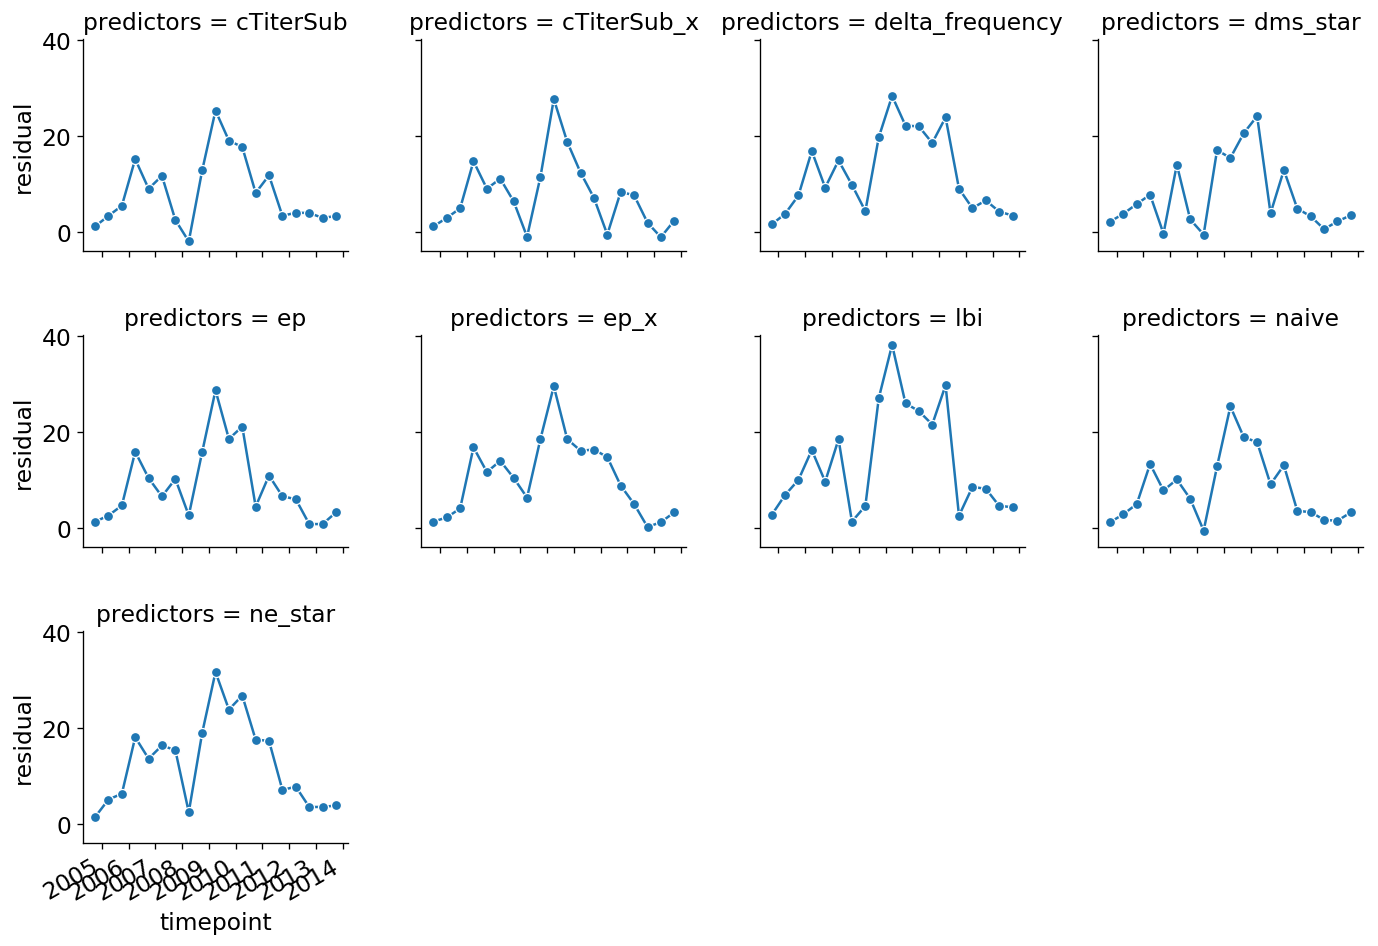

In [83]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [84]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([ 1.53698222,  4.00127821,  5.03985481,  2.91524055,  1.83484929,
        8.37180368,  4.73260739,  5.13062525, 14.20889925, 12.81086127,
        7.05861873,  6.46596883, 12.45154231, 16.67160628,  1.00082522,
        5.22865181,  6.4886886 ,  3.10944293,  1.07886655])

### Autocorrelation of residuals

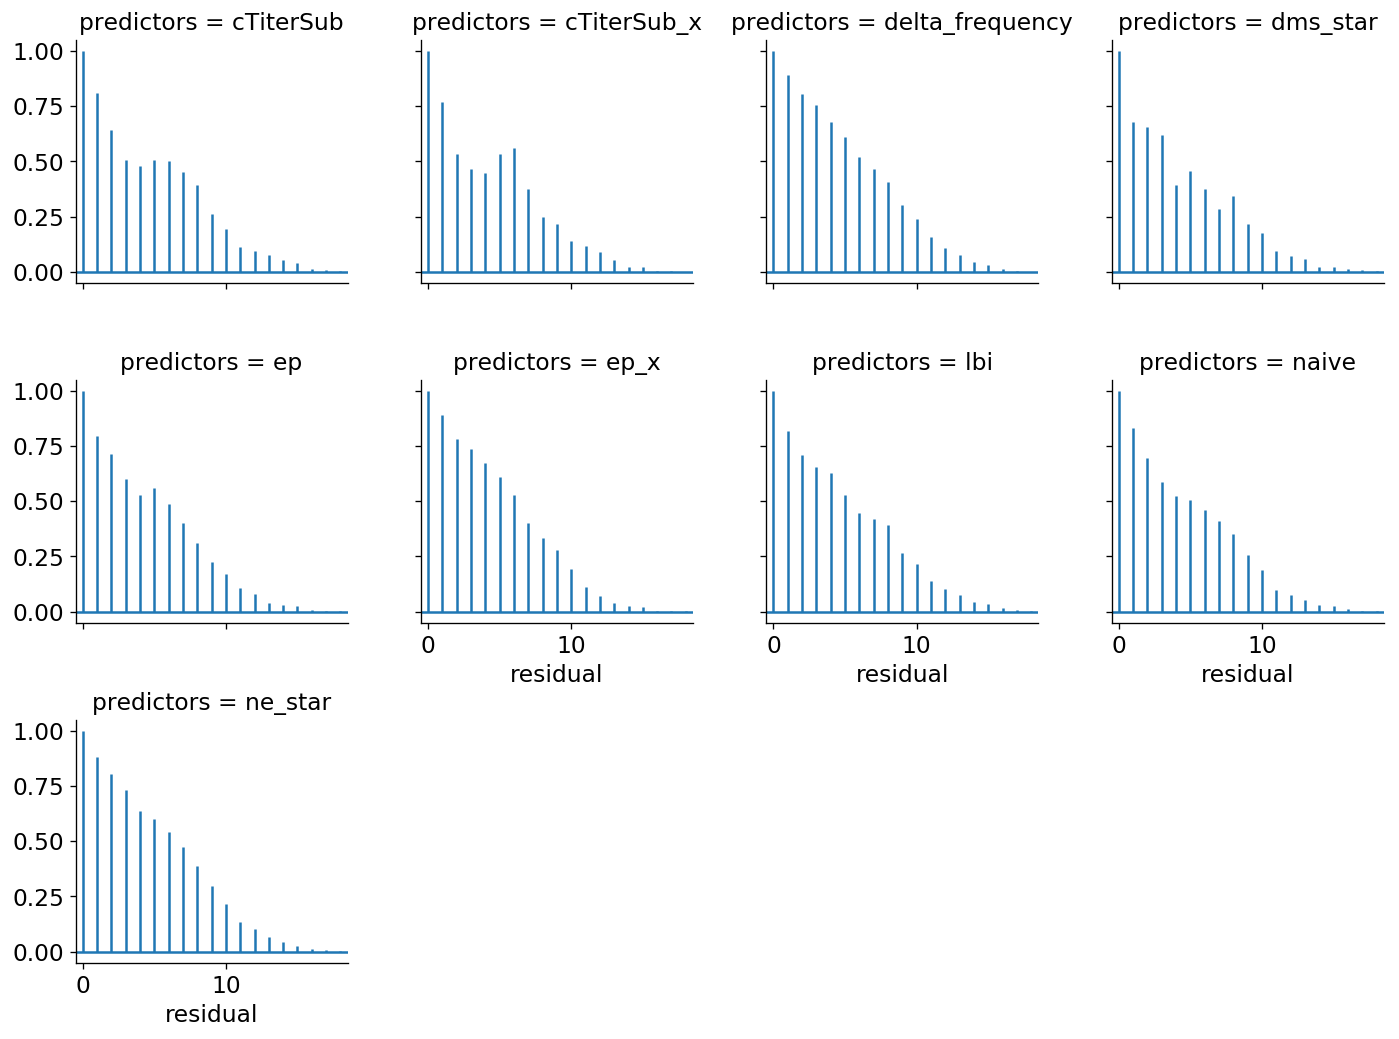

In [85]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted distances
[back to top](#Summarize-models)

$$
d_{i}(x(t)) = \sum_{j}x_{j}d_{ij}
$$

$$
u = t + \Delta{t}
$$

$$
\hat{x}_{i}(t, u) = x_{i}(t)e^{(f_{i}(t)(u - t))}
$$

$$
y = x_{i}(t)d_{i}(x(u))
$$

$$
\hat{y} = x_{i}(t)d_{i}(\hat{x}(t, u))
$$

$$
D(x(t), x(u)) = \sum_{i}x_{i}d_{i}(u)
$$

$$
D(\hat{x}(t, u), x(u)) = \sum_{i}x_{i}e^{(f_{i}(t)(u - t))}d_{i}(u)
$$

$$
L = \sum_{t}D(\hat{x}(t, u), x(u))
$$

In [86]:
frequency_df[frequency_df["predictors"] == "delta_frequency"].head()

strain  timepoint         y  frequency  \
2508     A/Adjame/GR765/2011 2011-10-01  0.141029   0.016677   
2509   A/Argentina/8823/2011 2011-10-01  0.245632   0.022372   
2510  A/Bangladesh/3564/2011 2011-10-01  0.158091   0.022640   
2511  A/Bangladesh/5006/2011 2011-10-01  0.130892   0.021878   
2512  A/Bangladesh/5071/2011 2011-10-01  0.128122   0.021415   

      projected_frequency  weighted_distance_to_future  \
2508         2.697937e-18                     8.456494   
2509         1.186424e-19                    10.979448   
2510         7.163016e-02                     6.982831   
2511         6.921928e-02                     5.982827   
2512         6.775441e-02                     5.982827   

      weighted_distance_to_present     y_hat        y_diff  residual  \
2508                      7.895304  0.084599  2.281509e-17  0.056430   
2509                      7.955716  0.247721  1.302628e-18 -0.002088   
2510                      7.101683  0.042765  5.001813e-01  0.115326   
2511                      6.159798  0.023471  4.141270e-01  0.107422   
2512                      6.159798  0.022974  4.053629e-01  0.105148   

     validation_timepoint       predictors  
2508           2011-10-01  delta_frequency  
2509           2011-10-01  delta_frequency  
2510           2011-10-01  delta_frequency  
2511           2011-10-01  delta_frequency  
2512           2011-10-01  delta_frequency

In [168]:
frequency_df["observed_rank"] = frequency_df["y"] / frequency_df["frequency"]
frequency_df["estimated_rank"] = frequency_df["y_hat"] / frequency_df["frequency"]

In [169]:
data_to_plot = frequency_df[frequency_df["predictors"] == "delta_frequency"]

In [170]:
minimum_observed_distance = data_to_plot.groupby("validation_timepoint")["observed_rank"].min().reset_index()

In [171]:
minimum_estimated_distance = data_to_plot.groupby("validation_timepoint")["estimated_rank"].min().reset_index()

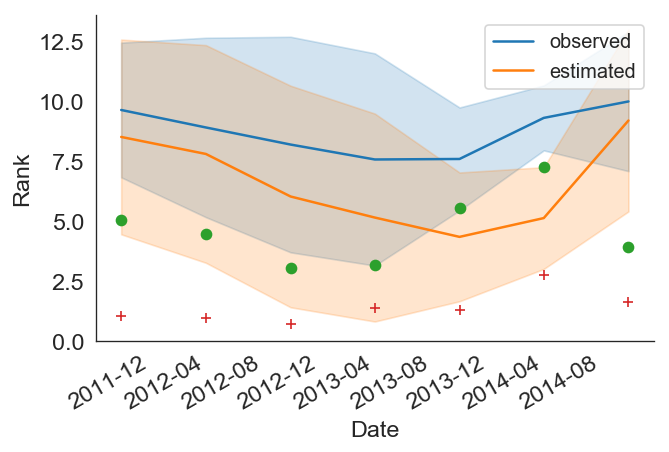

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = sns.lineplot(
    "validation_timepoint",
    "observed_rank",
    data=data_to_plot,
    ci="sd",
    label="observed",
    ax=ax
)

ax = sns.lineplot(
    "validation_timepoint",
    "estimated_rank",
    data=data_to_plot,
    ci="sd",
    label="estimated",
    ax=ax
)

ax.plot(
    minimum_observed_distance["validation_timepoint"],
    minimum_observed_distance["observed_rank"],
    "o",
    label="Minimum observed"
)

ax.plot(
    minimum_estimated_distance["validation_timepoint"],
    minimum_estimated_distance["estimated_rank"],
    "+",
    label="Minimum estimated"
)

ax.set_xlabel("Date")
ax.set_ylabel("Rank")
ax.set_ylim(bottom=0)
plt.gcf().autofmt_xdate()

In [125]:
vaccine_strains = [
    "A/Wisconsin/67/2005",
    "A/Brisbane/10/2007",
    "A/Perth/16/2009",
    "A/Victoria/361/2011",
    "A/Texas/50/2012",
    "A/Switzerland/9715293/2013",
    "A/HongKong/4801/2014"
]

In [177]:
vaccine_strain_data_to_plot = data_to_plot.loc[data_to_plot["strain"].isin(vaccine_strains),
                                               ["strain", "validation_timepoint", "observed_rank", "estimated_rank"]]

In [178]:
vaccine_strain_data_to_plot

strain validation_timepoint  observed_rank  \
2675         A/Victoria/361/2011           2012-04-01       6.695031   
2758             A/Texas/50/2012           2012-10-01       5.388144   
2968        A/HongKong/4801/2014           2014-04-01       7.265883   
3021  A/Switzerland/9715293/2013           2014-04-01       8.212952   
3068        A/HongKong/4801/2014           2014-10-01       3.945683   
3125  A/Switzerland/9715293/2013           2014-10-01      10.707659   

      estimated_rank  
2675        3.972907  
2758        3.729706  
2968       11.376220  
3021        5.835569  
3068        1.630982  
3125        9.770701

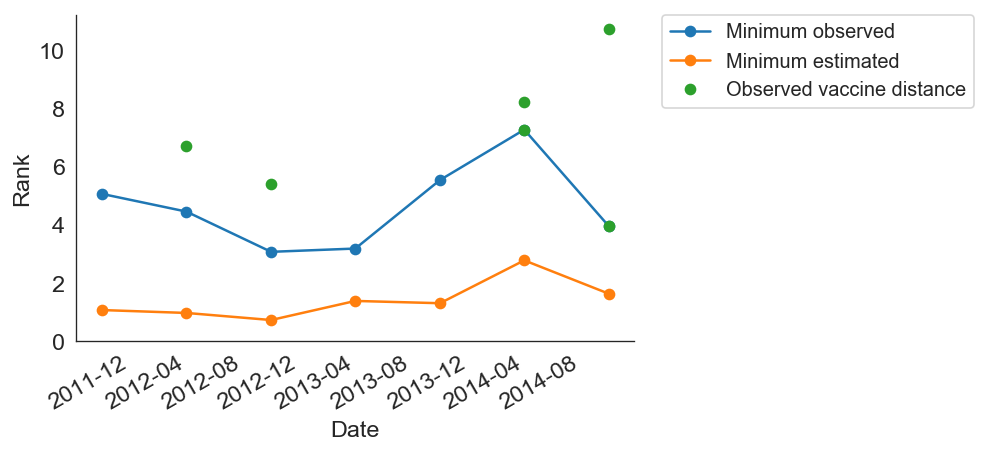

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(
    minimum_observed_distance["validation_timepoint"],
    minimum_observed_distance["observed_rank"],
    "o-",
    label="Minimum observed"
)

ax.plot(
    minimum_estimated_distance["validation_timepoint"],
    minimum_estimated_distance["estimated_rank"],
    "o-",
    label="Minimum estimated"
)

ax.plot(
    vaccine_strain_data_to_plot["validation_timepoint"],
    vaccine_strain_data_to_plot["observed_rank"],
    "o",
    label="Observed vaccine distance"
)

ax.set_xlabel("Date")
ax.set_ylabel("Rank")
ax.set_ylim(bottom=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.gcf().autofmt_xdate()

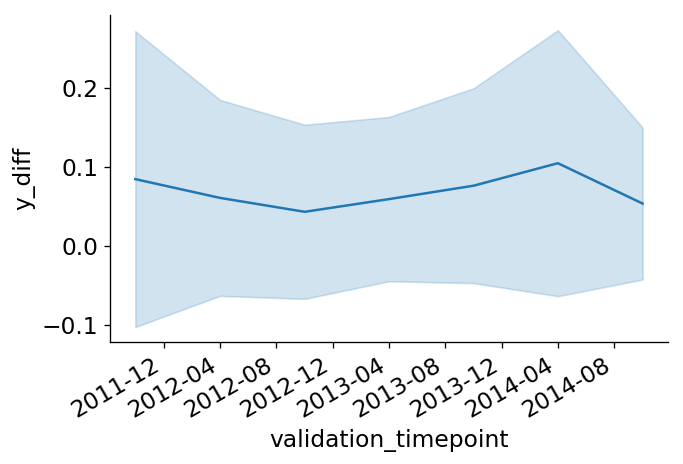

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = sns.lineplot(
    "validation_timepoint",
    "y_diff",
    data=frequency_df[frequency_df["predictors"] == "delta_frequency"],
    ci="sd",
    ax=ax
)

plt.gcf().autofmt_xdate()

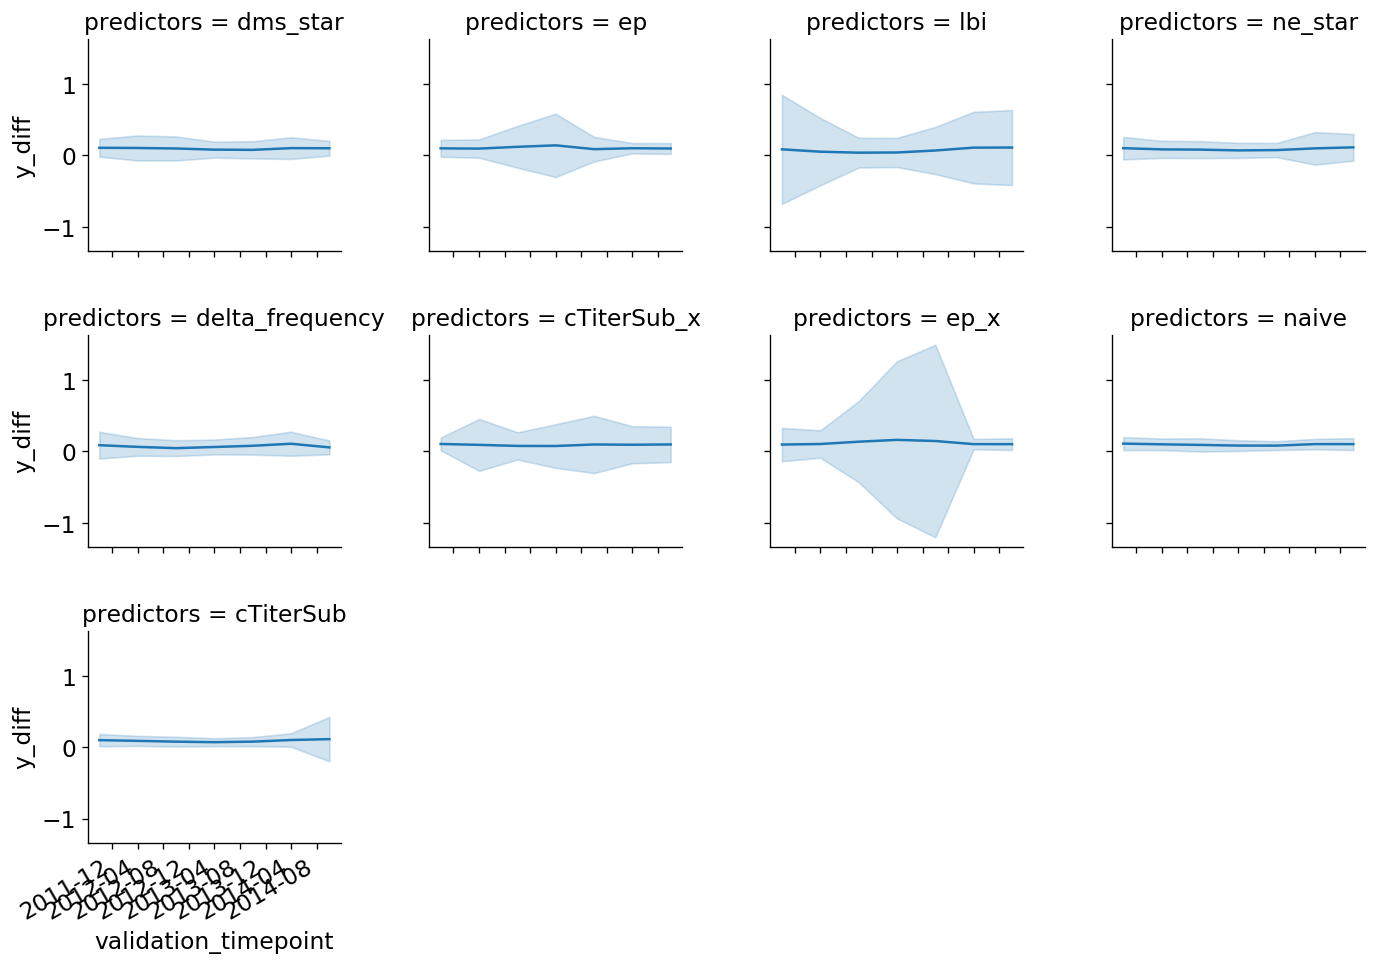

In [89]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(
    sns.lineplot,
    "validation_timepoint",
    "y_diff",
    ci="sd"
)
plt.gcf().autofmt_xdate()

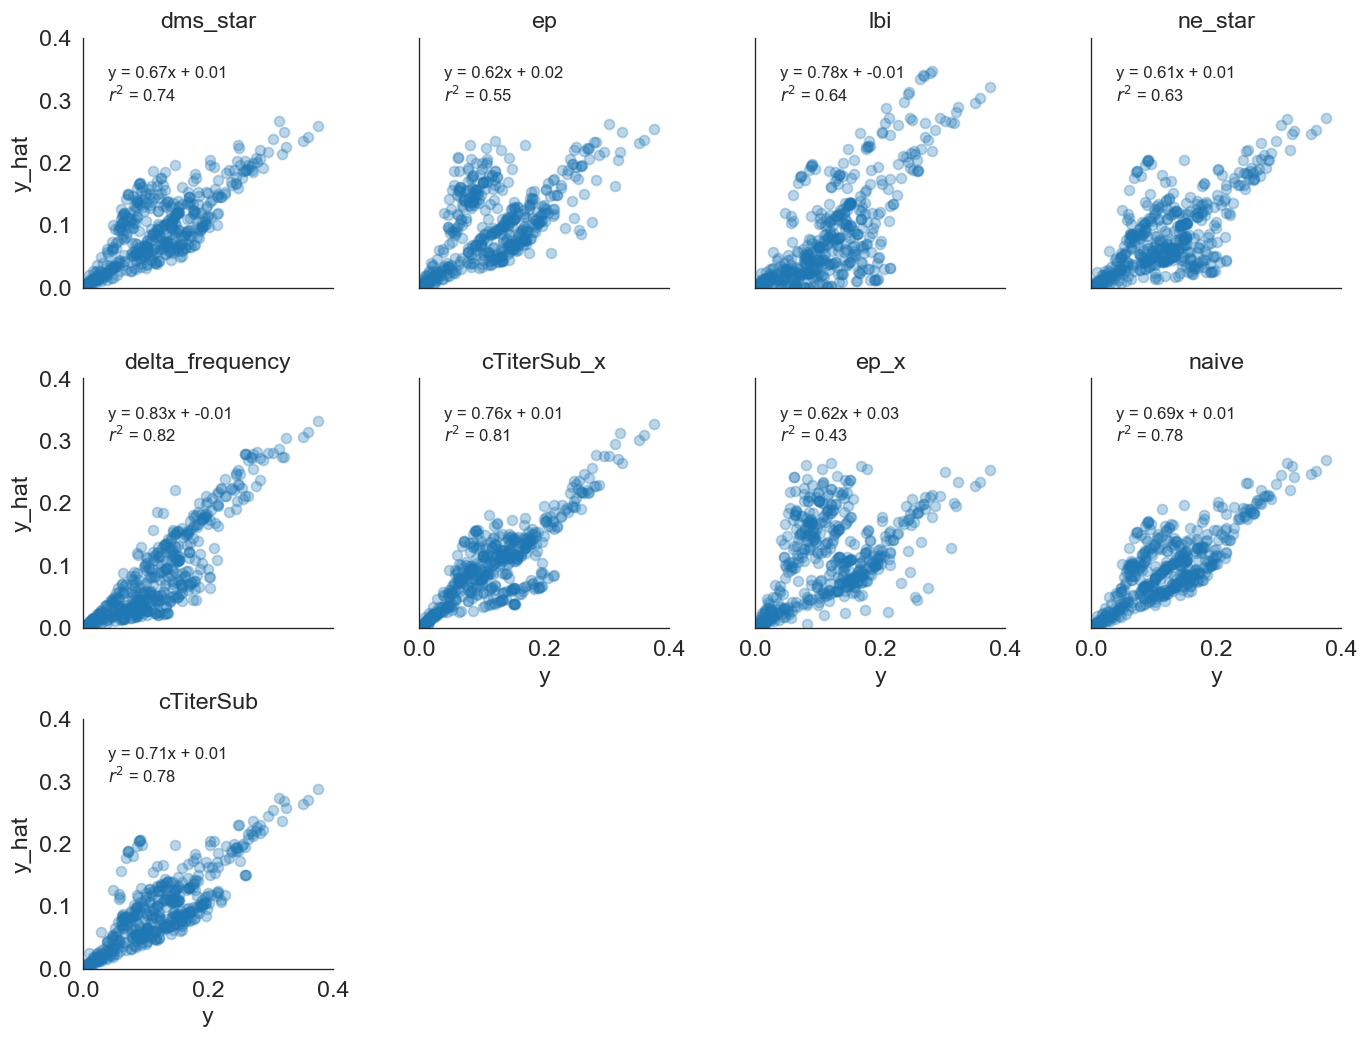

In [105]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, 0.4)
    ax.set_ylim(0, 0.4)

In [91]:
frequency_df["year_month"] = frequency_df["validation_timepoint"].dt.strftime("%Y-%m")

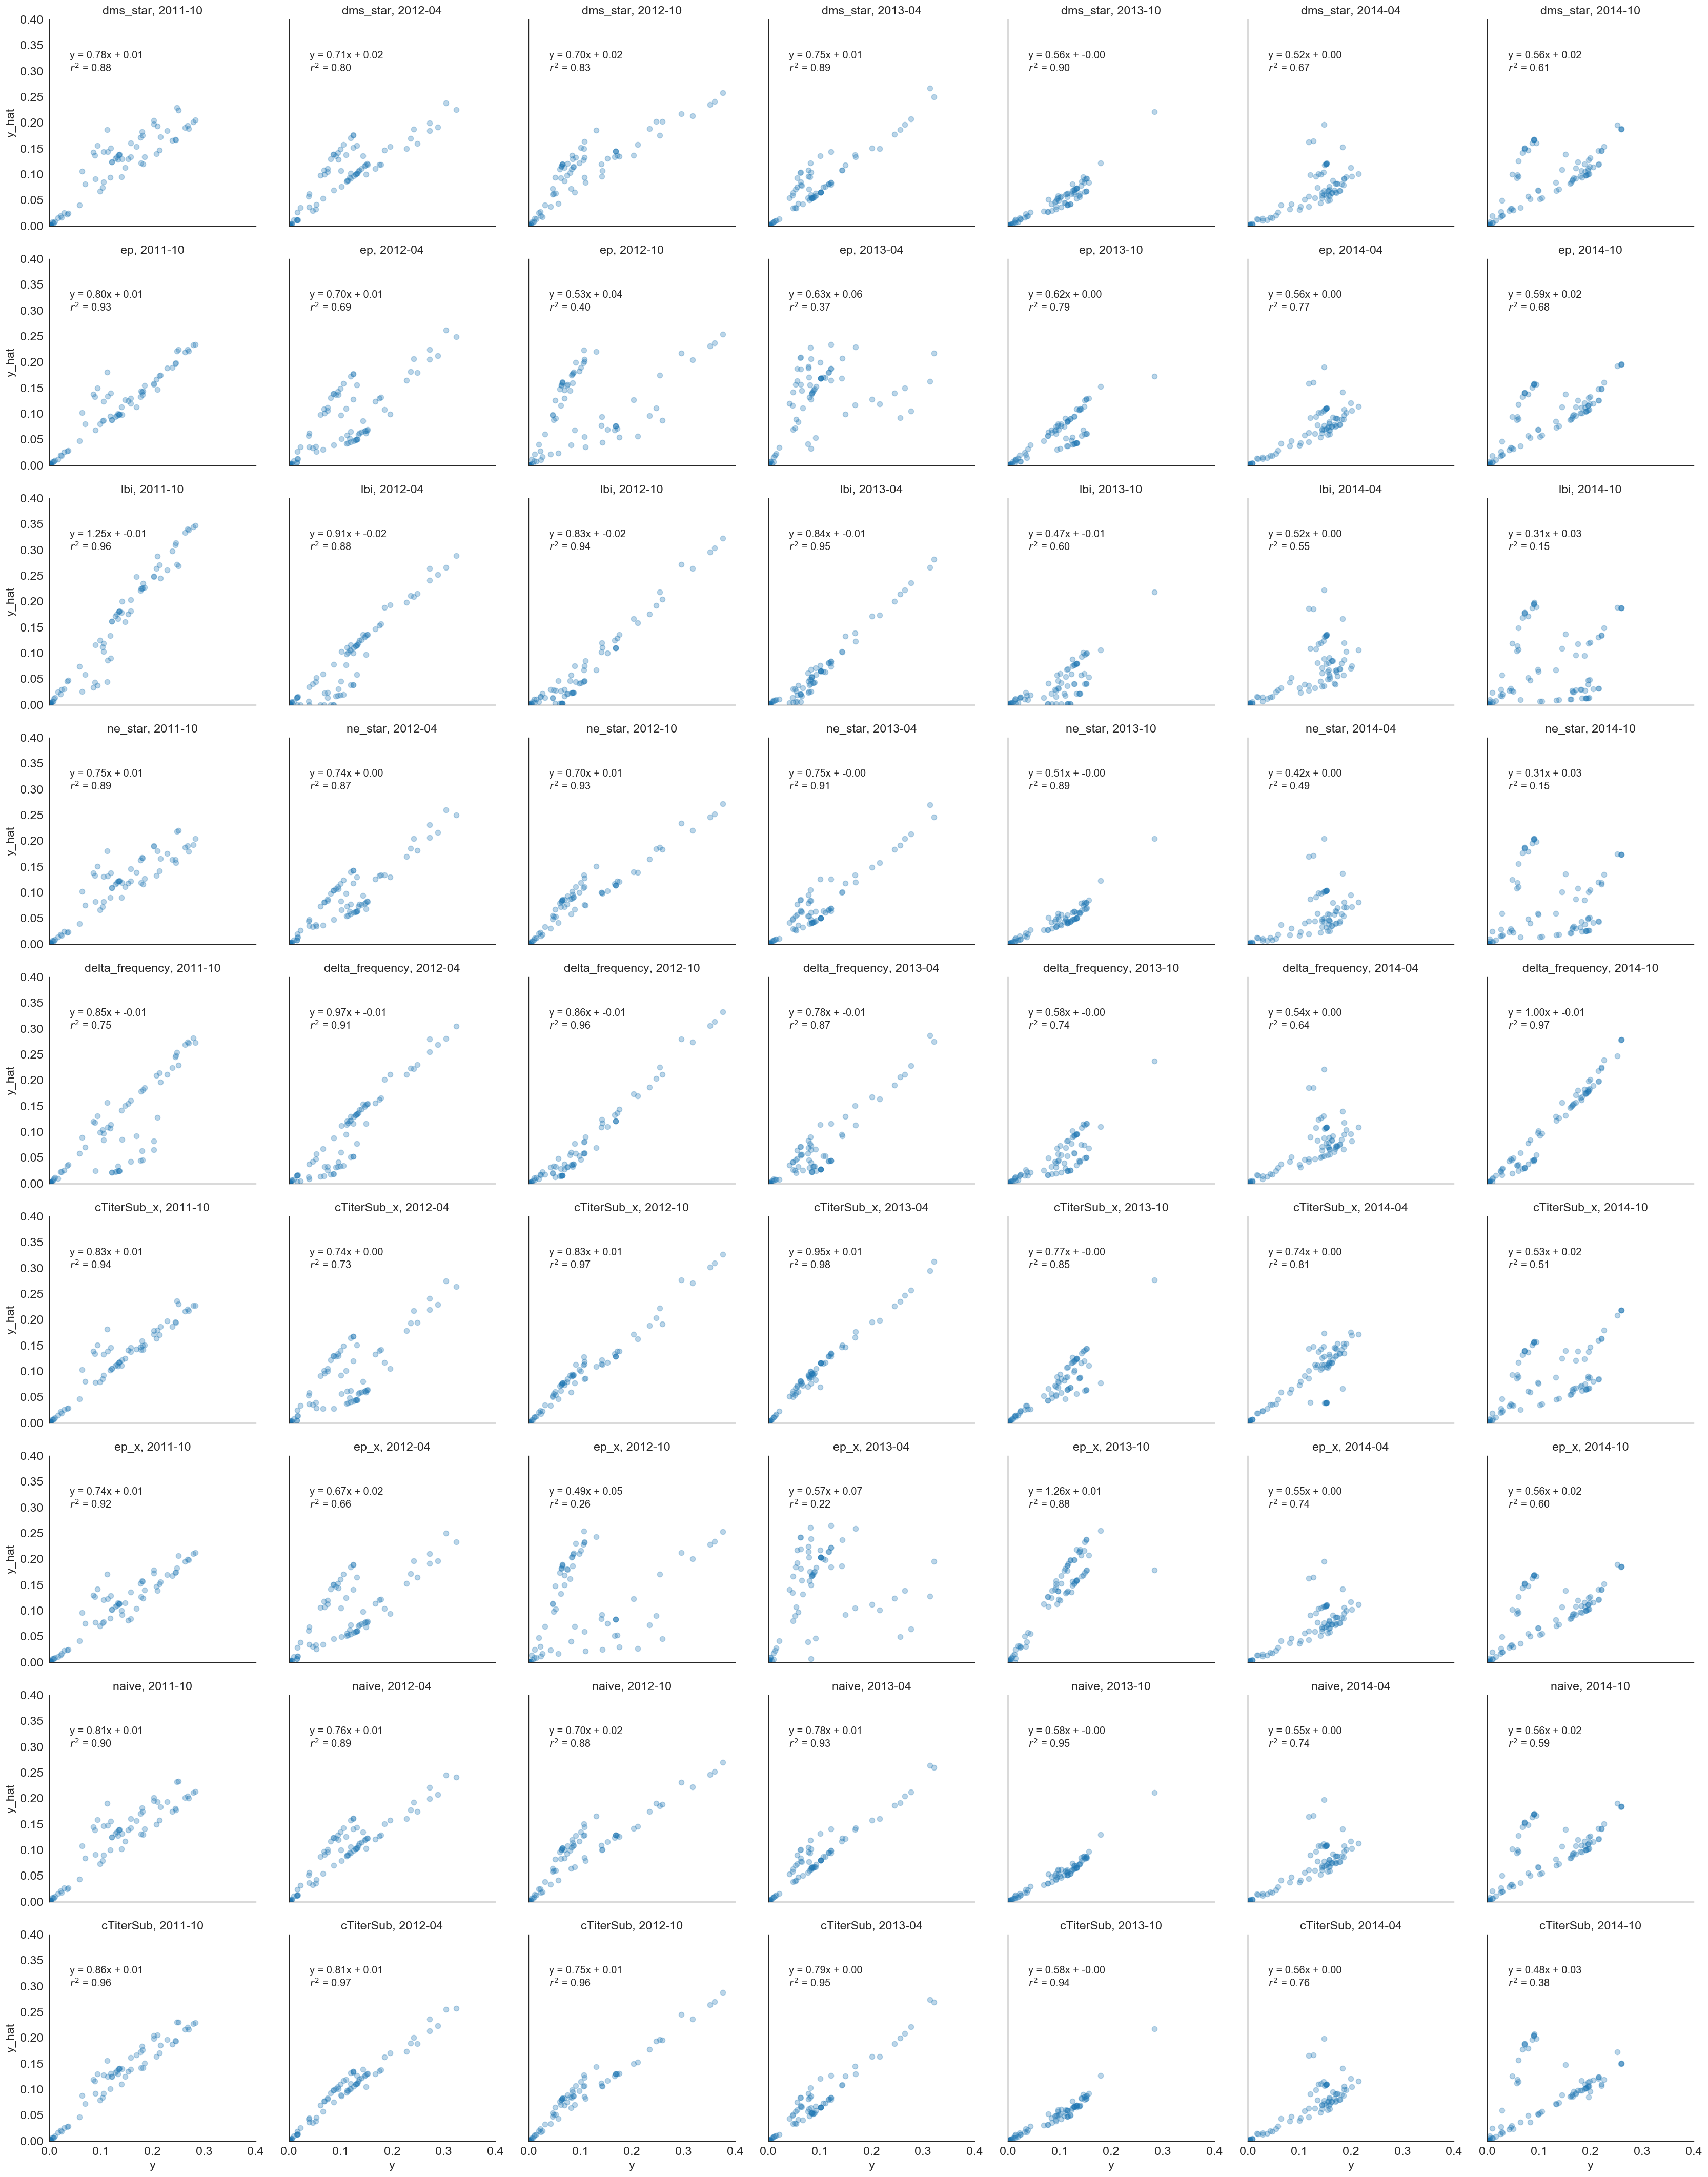

In [110]:
g = sns.FacetGrid(frequency_df, row="predictors", col="year_month", height=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{row_name}, {col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=12
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, 0.4)
    ax.set_ylim(0, 0.4)
    
plt.tight_layout()

## Summarize model forecasting error
[back to top](#Summarize-models)

### Weighted distances

In [186]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          8.727901            83           2011-10-01
1   dms_star          9.027530            88           2012-04-01
2   dms_star          8.318345            87           2012-10-01
3   dms_star          6.902983            87           2013-04-01
4   dms_star          7.025528            92           2013-10-01

In [191]:
distance_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [192]:
distance_df

predictors        sum       mean    median
0  delta_frequency  43.514848   6.216407  5.388905
1              lbi  44.804506   6.400644  6.217359
2          ne_star  55.143839   7.877691  7.306850
3      cTiterSub_x  55.685393   7.955056  8.479890
4        cTiterSub  56.368289   8.052613  7.797764
5            naive  58.339042   8.334149  8.550394
6         dms_star  58.936198   8.419457  8.727901
7               ep  65.185040   9.312149  9.196116
8             ep_x  74.351052  10.621579  9.646525

In [193]:
distance_df.loc[distance_df["predictors"] == "naive", "sum"].values[0]

58.33904246553055

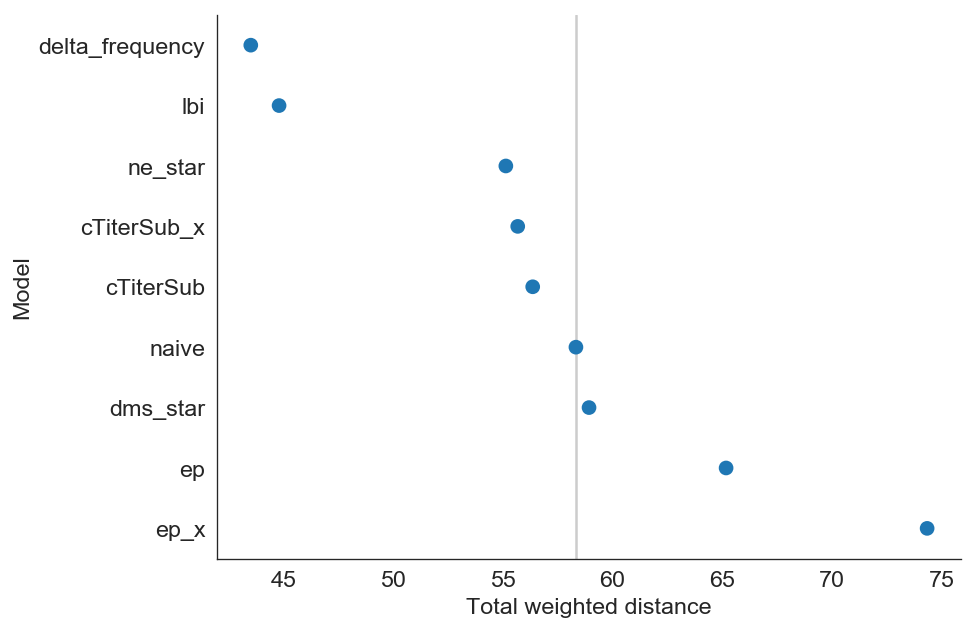

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="sum",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Total weighted distance")
ax.set_ylabel("Model")
ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "sum"].values[0],
    color="#cccccc",
    zorder=-10
)

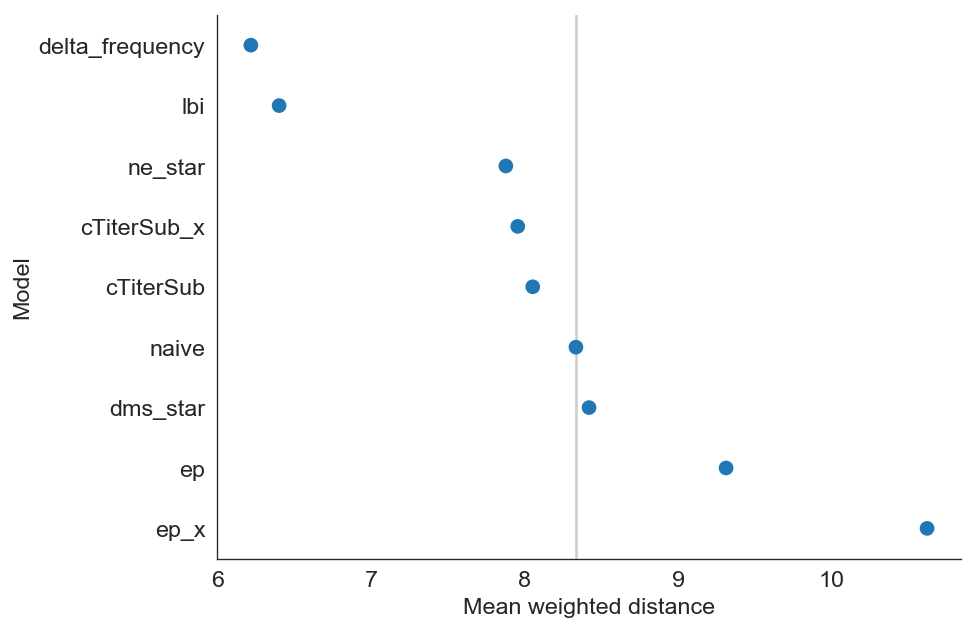

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mean",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Mean weighted distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "mean"].values[0],
    color="#cccccc",
    zorder=-10
)

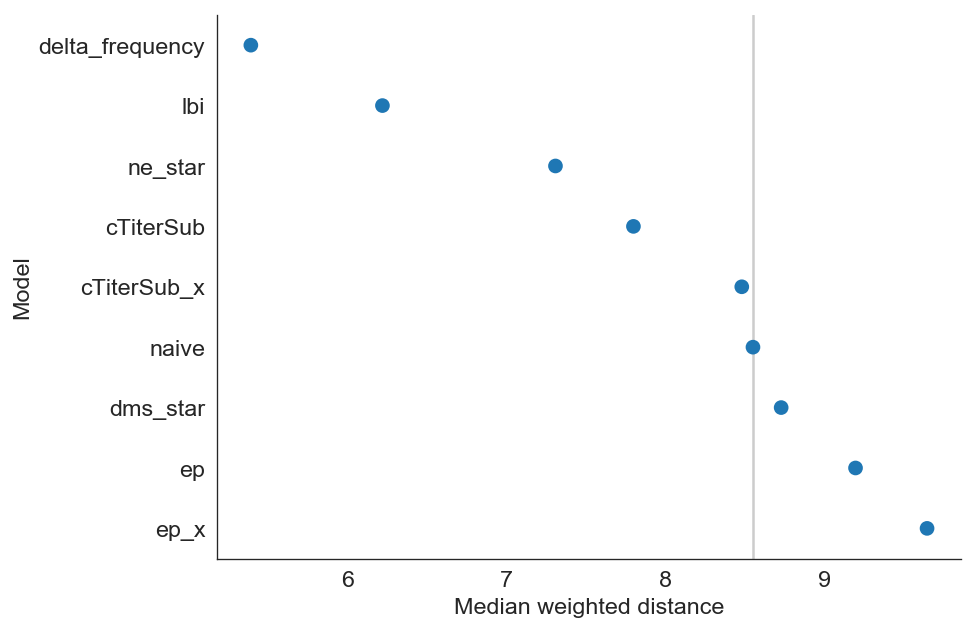

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="median",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Median weighted distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "median"].values[0],
    color="#cccccc",
    zorder=-10
)

In [198]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0   dms_star          8.727901            83           2011-10-01
1   dms_star          9.027530            88           2012-04-01
2   dms_star          8.318345            87           2012-10-01
3   dms_star          6.902983            87           2013-04-01
4   dms_star          7.025528            92           2013-10-01

(0, 14.431315970083347)

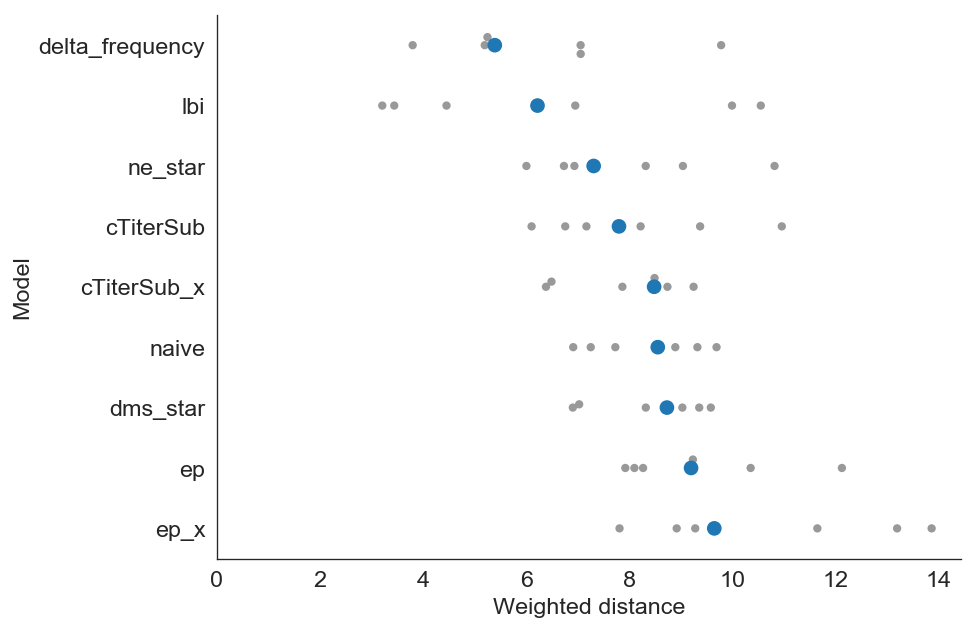

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"],
    color="#999999",
    zorder=-10
)

sns.pointplot(
    x="median",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Weighted distance")
ax.set_ylabel("Model")
ax.set_xlim(left=0)

In [200]:
predictor_type_order = [
    "naive",
    "ep",
    "cTiterSub",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [201]:
predictor_names = [
    "null",
    "epitope mutations",
    "HI phenotypes",
    "epitope cross-immunity",
    "HI cross-immunity",
    "non-epitope mutations",
    "DMS mutation effects",
    "LBI",
    "delta frequency"
]

In [202]:
predictor_name_by_id = dict(zip(predictor_type_order, predictor_names))

In [203]:
predictor_name_by_id

{'naive': 'null',
 'ep': 'epitope mutations',
 'cTiterSub': 'HI phenotypes',
 'ep_x': 'epitope cross-immunity',
 'cTiterSub_x': 'HI cross-immunity',
 'ne_star': 'non-epitope mutations',
 'dms_star': 'DMS mutation effects',
 'lbi': 'LBI',
 'delta_frequency': 'delta frequency'}

In [204]:
errors_by_time_df["predictors_name"] = errors_by_time_df["predictors"].map(predictor_name_by_id)

In [205]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

predictors  validation_error  validation_n validation_timepoint  \
49      naive          8.890606            83           2011-10-01   
50      naive          8.550394            88           2012-04-01   
51      naive          7.727628            87           2012-10-01   
52      naive          6.910641            87           2013-04-01   
53      naive          7.250390            92           2013-10-01   
54      naive          9.319065            93           2014-04-01   
55      naive          9.690318            97           2014-10-01   

   predictors_name  
49            null  
50            null  
51            null  
52            null  
53            null  
54            null  
55            null

In [208]:
individual_median_errors = []
for predictor in predictor_type_order:
    individual_median_errors.append(
        distance_df.loc[distance_df["predictors"] == predictor, "median"].values[0]
    )

(0, 14.423174255204076)

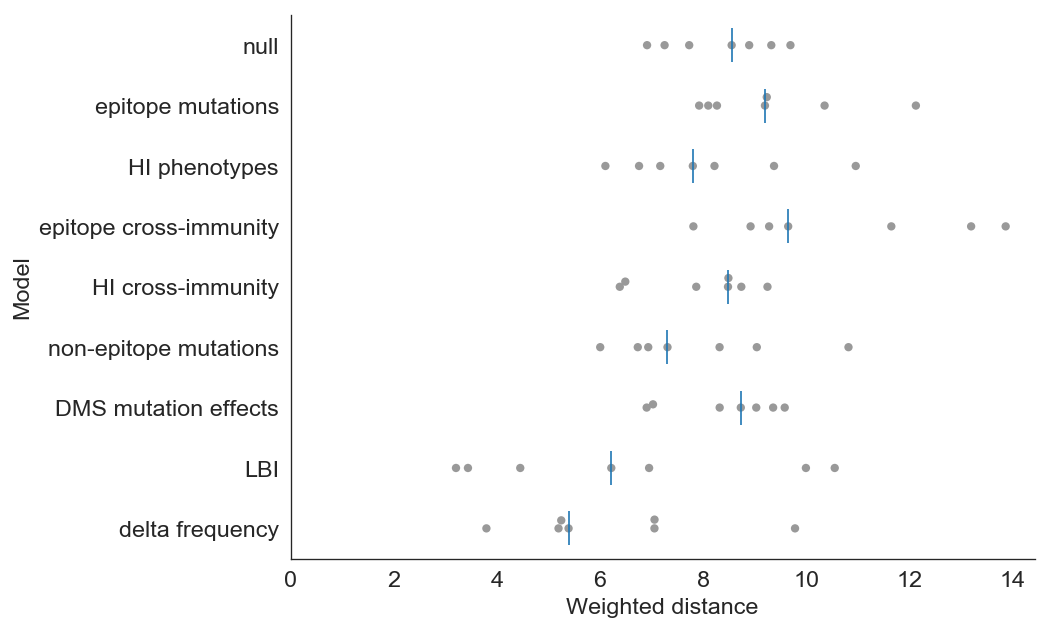

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    individual_median_errors,
    predictor_type_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=predictor_type_order,
    color="#999999",
    zorder=-10
)

ax.set_yticklabels(predictor_names)

ax.set_xlabel("Weighted distance")
ax.set_ylabel("Model")
ax.set_xlim(left=0)

In [210]:
errors_by_time_df[errors_by_time_df["predictors"].str.contains("-")]["predictors"].unique()

array([], dtype=object)

In [211]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

In [ ]:
composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI cross.",
    "LBI, delta frequency",
    "LBI, HI cross.",
    "LBI, DMS, HI cross.",
    "Luksza and Lassig"
]

In [ ]:
median_errors = []
for predictor in composite_predictors_order:
    median_errors.append(distance_df.loc[distance_df["predictors"] == predictor, "median"].values[0])

In [ ]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI phenotypes",
    "LBI, delta frequency",
    "LBI, HI phenotypes",
    "LBI, DMS, HI phenotypes",
    "Luksza and Lassig"
]

In [ ]:
median_errors

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    color="#999999",
    order=composite_predictors_order
)

ax.plot(
    median_errors,
    composite_predictors_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1.25, 1.25)
ax.set_yticklabels(composite_predictor_names)

#labels = ax.get_yticklabels()
#output = plt.setp(labels, rotation=30)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    color="#999999",
    order=composite_predictors_order
)

ax.plot(
    median_errors,
    composite_predictors_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlim(-1.25, 1.25)
ax.set_yticklabels(composite_predictor_names)

#labels = ax.get_yticklabels()
#output = plt.setp(labels, rotation=30)

ax.set_xlabel("Negative information gain (less is better)")
ax.set_ylabel("Model")
ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

plt.tight_layout()

In [ ]:
errors_by_time_df.loc[pd.isnull(errors_by_time_df["predictors_name"]), "predictors_name"] = errors_by_time_df.loc[
    pd.isnull(errors_by_time_df["predictors_name"]), "predictors"
]

In [ ]:
g = facet_time_plot(errors_by_time_df, "validation_error", "Weighted distance", timepoint_column="validation_timepoint")

In [ ]:
predictor_type_order

In [ ]:
antigenic_predictors = predictor_type_order[1:5]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(antigenic_predictors)],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in antigenic_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

In [ ]:
predictor_type_order

In [ ]:
functional_predictors = predictor_type_order[5:7]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(functional_predictors)],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in functional_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)


In [ ]:
growth_predictors = predictor_type_order[7:]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(growth_predictors)],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in growth_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

In [ ]:
errors_by_time_df["predictors"].unique()

In [ ]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

In [ ]:
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"] == "naive"],
    "validation_error",
    "Weighted distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    height=6,
    aspect=1
)
#g.set_titles("{col_name}")
#g.fig.subplots_adjust(hspace=0.2)

In [ ]:
errors_by_time_df.head()

In [ ]:
naive_error = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].values
for predictor in errors_by_time_df["predictors"].drop_duplicates().values:
    errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"] = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error

In [ ]:
g = facet_time_plot(errors_by_time_df, "adjusted_error", "adjusted weighted distance", timepoint_column="validation_timepoint")
g.set_titles("{col_name}")

## Summarize model coefficients

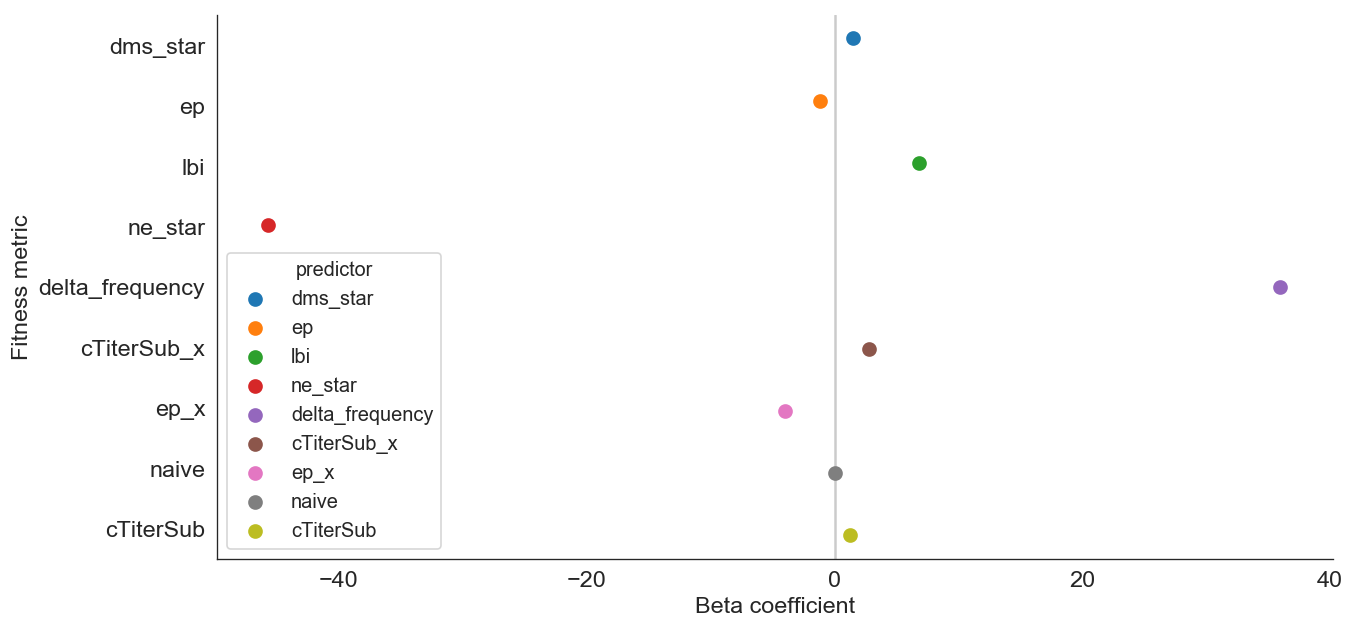

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False
    #order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [213]:
overall_coefficients_df

mean        predictor       predictors       std
0   1.454560         dms_star         dms_star  0.258667
1  -1.199790               ep               ep  0.624080
2   6.793879              lbi              lbi  5.298574
3 -45.720001          ne_star          ne_star  7.385225
4  35.953674  delta_frequency  delta_frequency  5.701734
5   2.766929      cTiterSub_x      cTiterSub_x  1.072421
6  -4.035515             ep_x             ep_x  4.417599
7   0.000000            naive            naive  0.000000
8   1.285459        cTiterSub        cTiterSub  0.489120

In [214]:
coefficients_by_time_df.head()

coefficient predictor predictors validation_timepoint
0     1.832915  dms_star   dms_star           2011-10-01
1     1.579110  dms_star   dms_star           2012-04-01
2     1.480932  dms_star   dms_star           2012-10-01
3     1.363663  dms_star   dms_star           2013-04-01
4     1.498426  dms_star   dms_star           2013-10-01

In [215]:
coefficients_by_time_df.tail()

coefficient  predictor predictors validation_timepoint
58     0.845872  cTiterSub  cTiterSub           2012-10-01
59     1.238033  cTiterSub  cTiterSub           2013-04-01
60     1.732541  cTiterSub  cTiterSub           2013-10-01
61     1.852229  cTiterSub  cTiterSub           2014-04-01
62     1.866728  cTiterSub  cTiterSub           2014-10-01

In [216]:
coefficients_by_time_df["predictors_name"] = coefficients_by_time_df["predictors"].map(predictor_name_by_id)

In [217]:
coefficients_by_time_df.loc[pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors_name"] = coefficients_by_time_df.loc[
    pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors"
]

In [218]:
coefficients_by_time_df["predictors_name"].unique().shape

(9,)

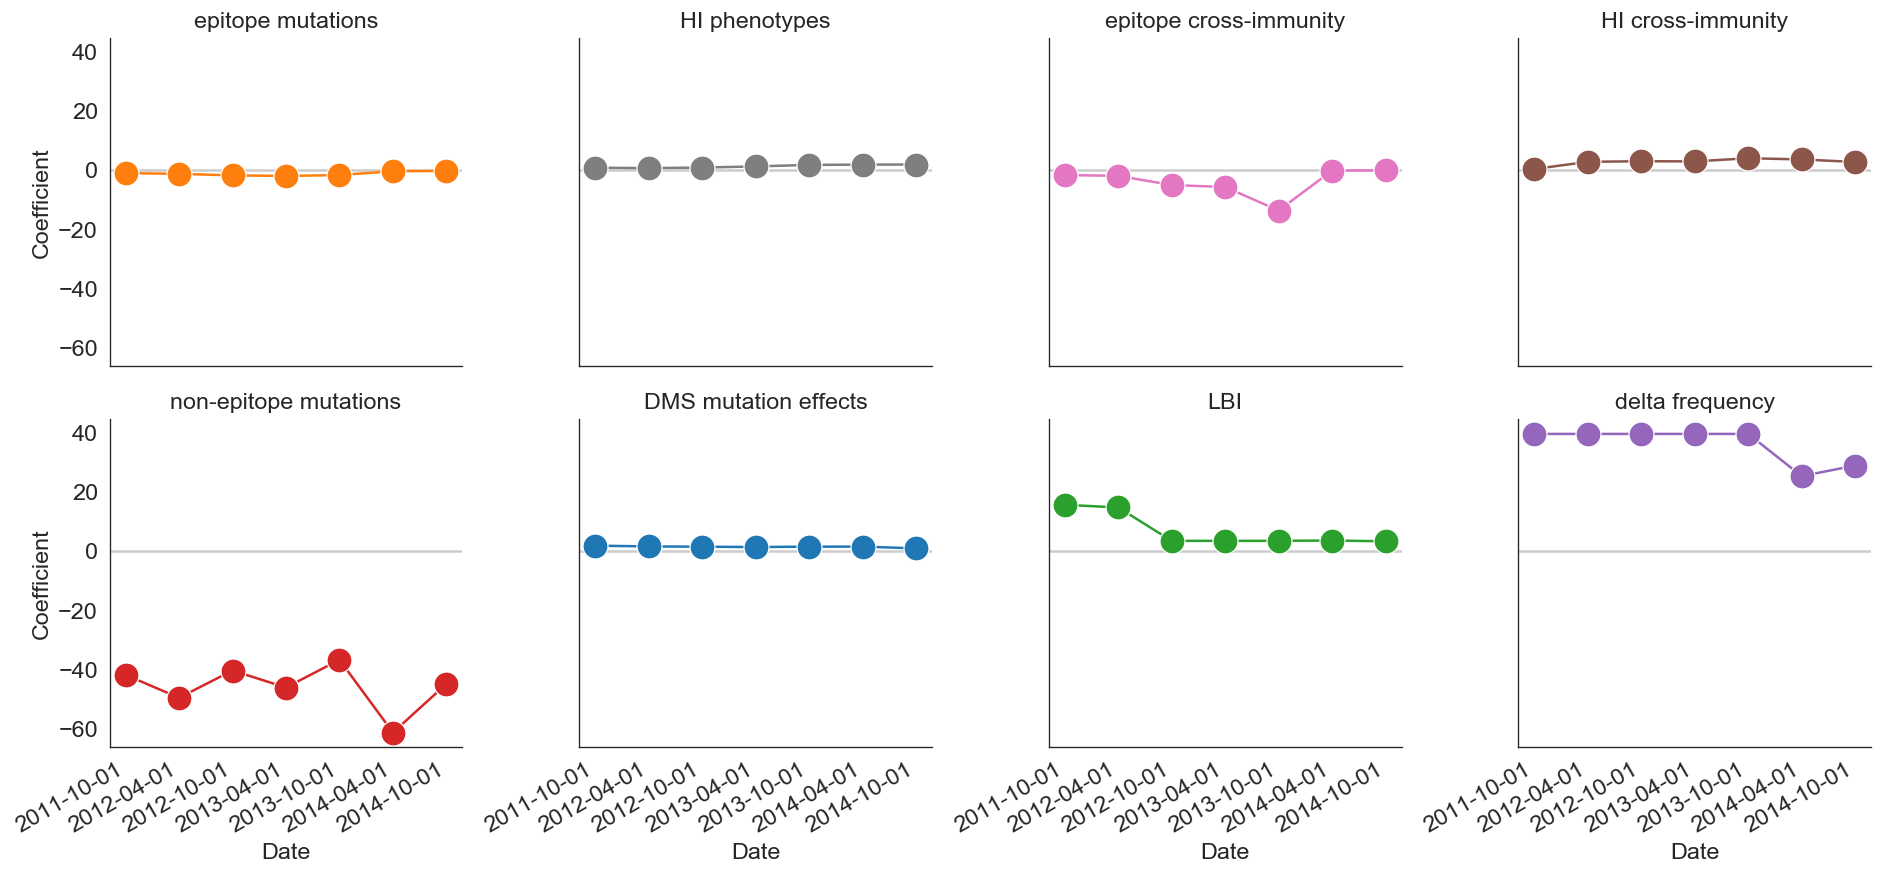

In [219]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_order=[predictor_name_by_id[predictor] for predictor in predictor_type_order[1:]],
    hue="predictor"
)
g.set_titles("{col_name}")

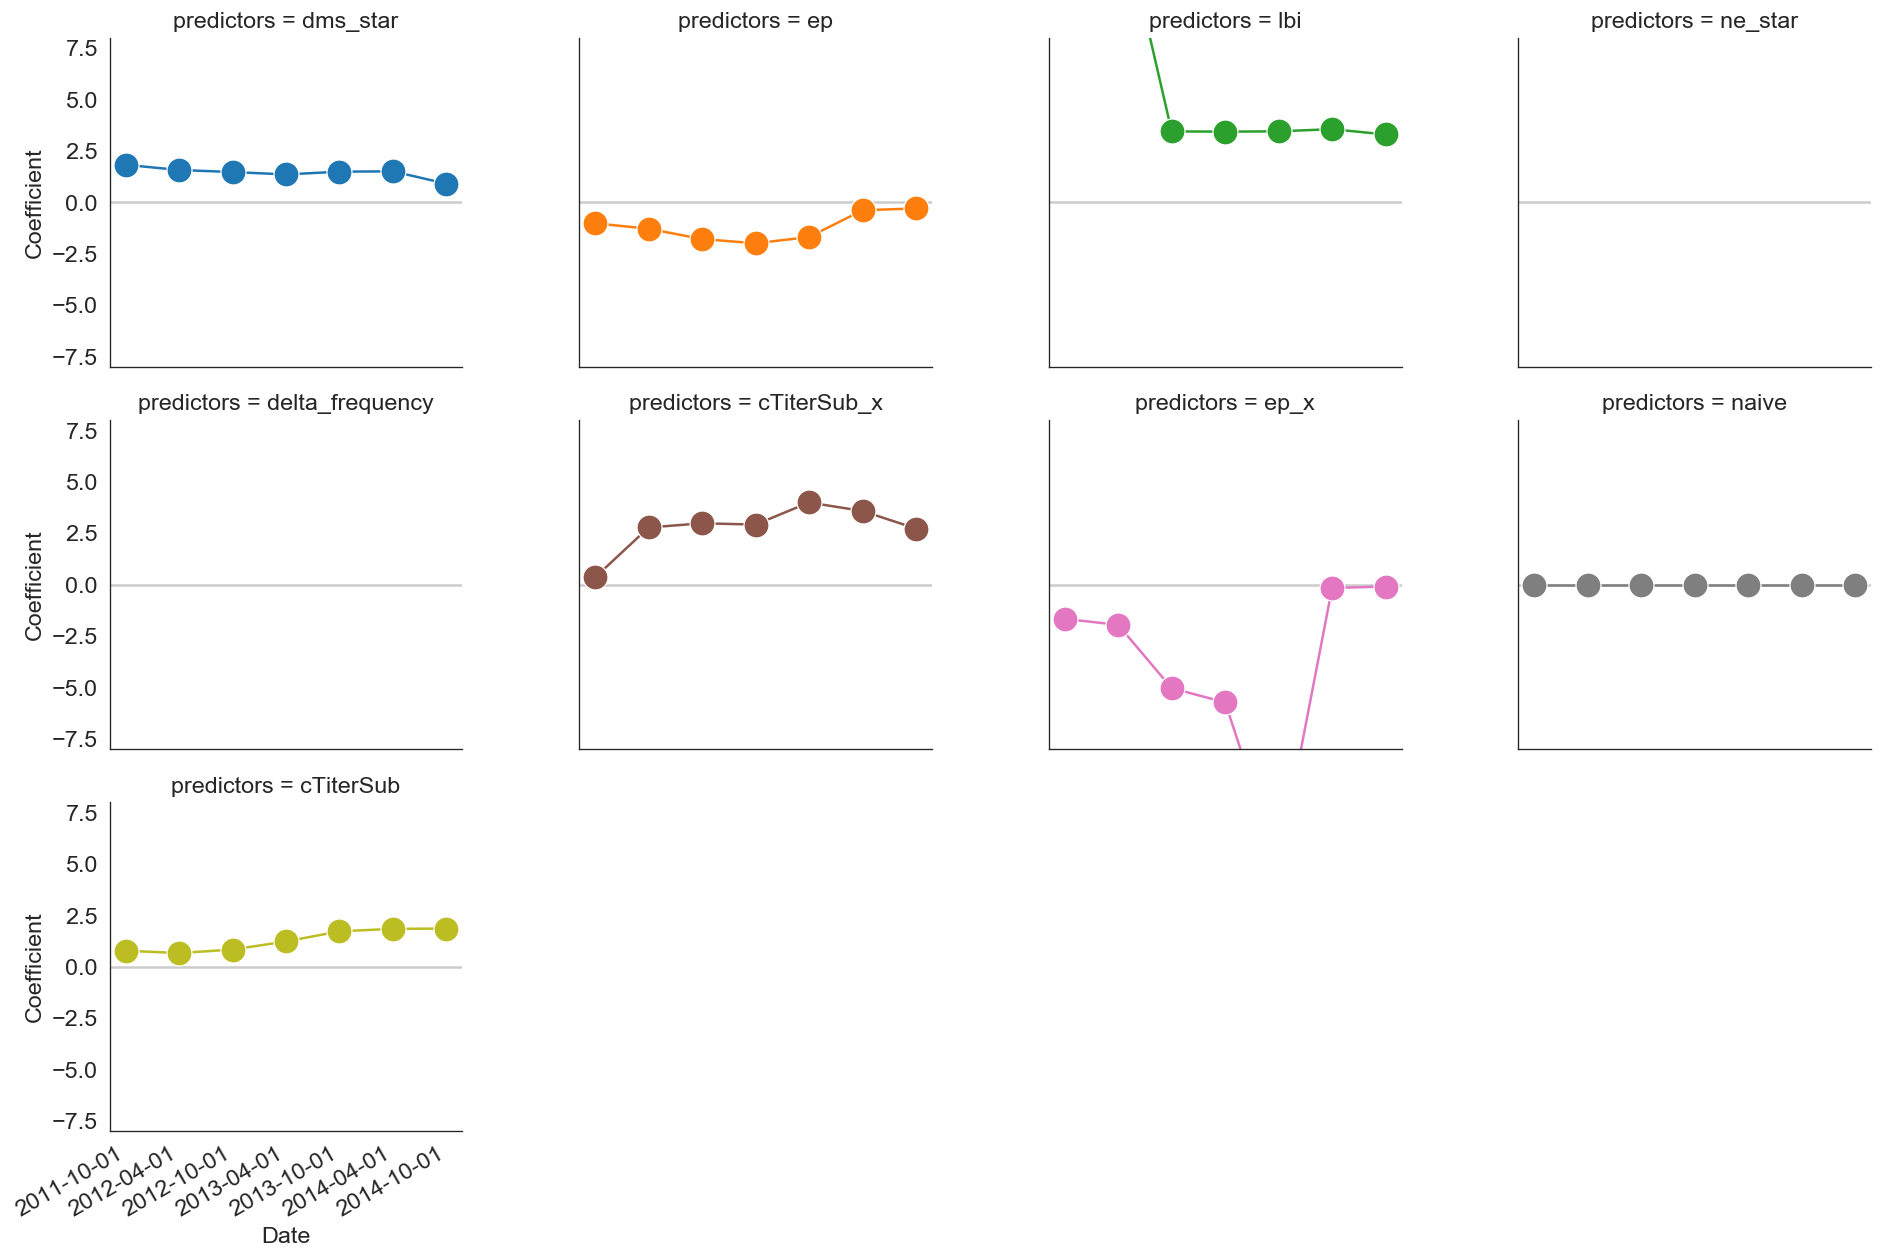

In [220]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

for ax in g.axes.flatten():
    ax.set_ylim(-8, 8)

In [221]:
print(coefficients_by_time_df.loc[coefficients_by_time_df["predictors"] == "ep", ["validation_timepoint", "coefficient"]])

   validation_timepoint  coefficient
7            2011-10-01    -1.012801
8            2012-04-01    -1.276254
9            2012-10-01    -1.779148
10           2013-04-01    -1.982828
11           2013-10-01    -1.680767
12           2014-04-01    -0.378016
13           2014-10-01    -0.288713


In [222]:
composite_predictors_order

['lbi',
 'delta_frequency',
 'cTiterSub_x',
 'lbi-delta_frequency',
 'lbi-cTiterSub_x',
 'lbi-dms_star-cTiterSub_x',
 'lbi-ep_x-ne_star']

In [ ]:
lbi_dfreq_order = ["lbi", "delta_frequency", "lbi-delta_frequency"]
lbi_dfreq_names = ["LBI", "delta frequency", "LBI, delta frequency"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    ax.set_ylim(-2., 2.)

In [ ]:
lbi_dfreq_order = ["lbi", "cTiterSub_x", "lbi-cTiterSub_x"]
lbi_dfreq_names = ["LBI", "HI cross-immunity", "LBI, HI cross-immunity"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    ax.set_ylim(-2., 2.)